<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 5.  Соревнование Kaggle "Catch Me If You Can"

На этой неделе мы вспомним про концепцию стохастического градиентного спуска и опробуем классификатор Scikit-learn SGDClassifier, который работает намного быстрее на больших выборках, чем алгоритмы, которые мы тестировали на 4 неделе. Также мы познакомимся с данными [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle по идентификации пользователей и сделаем в нем первые посылки. По итогам этой недели дополнительные баллы получат те, кто попадет в топ-30 публичного лидерборда соревнования.

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Стохатический градиентный спуск](https://www.coursera.org/learn/supervised-learning/lecture/xRY50/stokhastichieskii-ghradiientnyi-spusk)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   
**Также рекомендуется вернуться и просмотреть [задание](https://www.coursera.org/learn/supervised-learning/programming/t2Idc/linieinaia-rieghriessiia-i-stokhastichieskii-ghradiientnyi-spusk) "Линейная регрессия и стохастический градиентный спуск" 1 недели 2 курса специализации.**

### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1pLsegkAICL9PzOLyAeH9DmDOBfktte0l8JW75uWcTng). 

In [1]:
import warnings

warnings.filterwarnings("ignore")
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score


%load_ext autoreload
%autoreload 2
%load_ext lab_black
%load_ext watermark

%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn,catboost,xgboost,lightgbm -g

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.22.0

numpy      : 1.20.2
scipy      : 1.6.2
pandas     : 1.2.5
matplotlib : 3.3.4
statsmodels: 0.12.2
sklearn    : 0.24.2
catboost   : 0.26
xgboost    : 1.3.3
lightgbm   : 3.1.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: 



**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = (
    "data/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2"
)

In [3]:
train_df = pd.read_csv(
    os.path.join(PATH_TO_DATA, "train_sessions.csv"), index_col="session_id"
)
test_df = pd.read_csv(
    os.path.join(PATH_TO_DATA, "test_sessions.csv"), index_col="session_id"
)

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


**Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.**

In [5]:
train_test_df = pd.concat([train_df, test_df])

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

**Посмотрим на статистику признаков.**

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   site1   253561 non-null  int64  
 1   time1   253561 non-null  object 
 2   site2   250098 non-null  float64
 3   time2   250098 non-null  object 
 4   site3   246919 non-null  float64
 5   time3   246919 non-null  object 
 6   site4   244321 non-null  float64
 7   time4   244321 non-null  object 
 8   site5   241829 non-null  float64
 9   time5   241829 non-null  object 
 10  site6   239495 non-null  float64
 11  time6   239495 non-null  object 
 12  site7   237297 non-null  float64
 13  time7   237297 non-null  object 
 14  site8   235224 non-null  float64
 15  time8   235224 non-null  object 
 16  site9   233084 non-null  float64
 17  time9   233084 non-null  object 
 18  site10  231052 non-null  float64
 19  time10  231052 non-null  object 
 20  target  253561 non-null  int64  
dtypes: float64

In [7]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   site1   82797 non-null  int64  
 1   time1   82797 non-null  object 
 2   site2   81308 non-null  float64
 3   time2   81308 non-null  object 
 4   site3   80075 non-null  float64
 5   time3   80075 non-null  object 
 6   site4   79182 non-null  float64
 7   time4   79182 non-null  object 
 8   site5   78341 non-null  float64
 9   time5   78341 non-null  object 
 10  site6   77566 non-null  float64
 11  time6   77566 non-null  object 
 12  site7   76840 non-null  float64
 13  time7   76840 non-null  object 
 14  site8   76151 non-null  float64
 15  time8   76151 non-null  object 
 16  site9   75484 non-null  float64
 17  time9   75484 non-null  object 
 18  site10  74806 non-null  float64
 19  time10  74806 non-null  object 
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [9]:
train_df["target"].value_counts()

0    251264
1      2297
Name: target, dtype: int64

**Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [10]:
train_test_df_sites = (
    train_test_df[["site%d" % i for i in range(1, 11)]].fillna(0).astype("int")
)

In [11]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


**Создайте разреженные матрицы *X_train_sparse* и *X_test_sparse* аналогично тому, как мы это делали ранее. Используйте объединенную матрицу *train_test_df_sites*, потом разделите обратно на обучающую и тестовую части.**

Обратите внимание на то, что в  сессиях меньше 10 сайтов  у нас остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом $i$). Поэтому первый столбец разреженной матрицы надо будет удалить.

**Выделите в отдельный вектор *y* ответы на обучающей выборке.**

In [12]:
def make_sparse_data(data):
    indptr = [0]
    indices = []
    sparse_data = []
    for row in data:
        val, cnt = np.unique(row[row != 0], return_counts=True)
        indptr.append(indptr[-1] + len(val))
        for v, c in zip(val, cnt):
            indices.append(v - 1)
            sparse_data.append(c)
    return np.uint64(sparse_data), np.uint64(indices), np.uint64(indptr)


train_test_sparse = csr_matrix(make_sparse_data(train_test_df_sites.values))
X_train_sparse = train_test_sparse[: len(train_df)]
X_test_sparse = train_test_sparse[len(train_df) :]
y = train_df.target

In [13]:
with open(os.path.join(PATH_TO_DATA, "site_dic.pkl"), "rb") as f:
    site_dic = pickle.load(f)

In [14]:
len(site_dic)

48371

**<font color='red'>Вопрос 1. </font> Выведите размерности матриц *X_train_sparse* и *X_test_sparse* – 4 числа на одной строке через пробел: число строк и столбцов матрицы *X_train_sparse*, затем число строк и столбцов матрицы *X_test_sparse*.**

In [15]:
print("Train df:", train_df.shape)
print("Test df:", test_df.shape)

Train df: (253561, 21)
Test df: (82797, 20)


In [16]:
print("Train:", X_train_sparse.shape)
print("Test:", X_test_sparse.shape)

Train: (253561, 48371)
Test: (82797, 48371)


**Сохраним в pickle-файлы объекты *X_train_sparse*, *X_test_sparse* и *y* (последний – в файл *kaggle_data/train_target.pkl*).**

In [17]:
with open(os.path.join(PATH_TO_DATA, "X_train_sparse.pkl"), "wb") as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, "X_test_sparse.pkl"), "wb") as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, "train_target.pkl"), "wb") as train_target_pkl:
    pickle.dump(y, train_target_pkl, protocol=2)

**Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.**

In [18]:
train_share = int(0.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid = X_train_sparse[train_share:, :], y[train_share:]

**Создайте объект `sklearn.linear_model.SGDClassifier` с логистической функцией потерь и параметром *random_state*=17. Остальные параметры оставьте по умолчанию, разве что *n_jobs*=-1 никогда не помешает. Обучите  модель на выборке `(X_train, y_train)`.**

In [19]:
sgd_logit = SGDClassifier(loss="log", random_state=17, n_jobs=-1)
sgd_logit.fit(X_train, y_train)

SGDClassifier(loss='log', n_jobs=-1, random_state=17)

**Сделайте прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)*.**

In [20]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)[:, 1]

**<font color='red'>Вопрос 2. </font> Посчитайте ROC AUC логистической регрессии, обученной с помощью стохастического градиентного спуска, на отложенной выборке. Округлите до 3 знаков после разделителя.**

In [21]:
roc_auc = roc_auc_score(y_valid, logit_valid_pred_proba)

In [22]:
round(roc_auc, 3)

0.934

**Сделайте прогноз в виде предсказанных вероятностей отнесения к классу 1 для тестовой выборки с помощью той же *sgd_logit*, обученной уже на всей обучающей выборке (а не на 70%).**

In [23]:
%%time
sgd_logit.fit(X_train_sparse, y)
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)[:,1]

Wall time: 456 ms


**Запишите ответы в файл и сделайте посылку на Kaggle. Дайте своей команде (из одного человека) на Kaggle говорящее название – по шаблону "[YDF & MIPT] Coursera_Username", чтоб можно было легко идентифицировать Вашу посылку на [лидерборде](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard/public).**

**Результат, который мы только что получили, соответствует бейзлайну "SGDCLassifer" на лидерборде, задача на эту неделю – как минимум его побить.**

In [24]:
def write_to_submission_file(
    predicted_labels, out_file, target="target", index_label="session_id"
):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(1, predicted_labels.shape[0] + 1),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

In [25]:
write_to_submission_file(logit_test_pred_proba, "submission.txt")

### Бенчмарки

1. sgd_logit_benchmark.csv - 0.91273
2. Logit +3 features 0.92784

In [26]:
base64_img = "iVBORw0KGgoAAAANSUhEUgAAA84AAACiCAYAAACQy5TkAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAEpWSURBVHhe7Z0HXFVXuvZJbmbu/e439363TZKZ3MkkM5PqJFGTWJKJSYw9lsQ0RbHH2HvUaDT2WNBYYiHBEhUFFaxYQbGABUFBlCJFQJpIEQ9NhOdba5dz9jkc4HA0Ccjz5PcP7L3XXmvtdY6H/ez3Xeu4wAElJl3Tfqs/KkiJQEREBE7uXo7xg5fj3A3tgFB5ZjCWDHLDKPe18N28GtOHT4HP1tX4dGEQ8mWBigR4j+iMQd8FIVs5Q9X1gHn4bHkwCrVti0wIWvI+lpzM1bbrl5I3f4gnenjBMERm3QlzRzMXF+V4irbPrIoQTBPH+ntnaDssunVwHB76rSv8M8WGVq5Fn6lwX+huZsn6ENxSi9uoGEEzWuCRP3bCwH4t8R9vzsF5k3jdckPww0JPhCovkrVKg+fg4X+fgzDx+5lvG+OpQb5K3WWxnmjn0gleCep16mWADKzr7oKX5oYoW3ofn3ipNVq3Fbz7Ah4V2//y3EDss/P2l+099Jvu8Luu7bCSWre9cdGl9utxzA0qVndUJGJlaxe8pvdHSOnvv45HcIm2Q6iiKBAjRb++2KHWfTfFC11EPd+pF6Vtu2DJWXVbKmvHAPz2SfW6y3P98bmxXdtxsNmWfXAR9elUOX52VFGQiPNHA7HX63t8Nai1Mp56vxzpt1RFQQimv+6CNlO+x8T3XPD0F+74rtdjeL6f9fvReL4ytg91h89p+3XqkmP55X+5oOeGRG1PMQ6MU9/r9v4tUBRFUdWr4LYJtwQVFRXqdkEezl05hV0HN2HMgr74qO87cGvVDP07tET3Qe/hsw6f4ItGn8Oj5yCcWt0BUbubY9+8LpjyjwHo/ed+GPrKaPit3IXk2GTs37Abmxd0xdIFoxF7OQp3yu4obYTmVaDzcWB42F1lu74r0kvcTwbJmyejcnFkXmesCLZ/n1lRFA2vr9zwxYzV2OS7FvOHDcXKbRsxs6sP4rUyRpVF+1jueQ2K8RuFrn0WIdjqnjkIM7ssR2iBul1RkoDN4yZgn/6nsyIaG9+fh+Cb2raQI/VQtVPWsXno7ROtbdUvlWeGw+OHcCtPpaoQMYc9cDRed1YFiNrni6gcbVNTacpprA24iiJt+150r572gTXORqXunwHXDRFQP2I13TUhOUaa62hkCVNWGLbW8IZUP6BsjXD5DfGP3s6HUFm8H0aN9sFVqwbqj6ozztWZ4+qOnXFvrJi1KLlRXR12dCtgKh59uCVWRYgNYSjXu6pG6eqJOXjsX4YjsAbjLI1Tq4dUs2w00Y4Y587f+CJQmD3JsYuJKC5TD9vqXo1zzOp3rQypzm+enGo2ytb91WQzlsq1Pmzphz0DWn7DF32ESZX75AMNYxt6X9ssDbfa1selMCXcPB4Kx65oDzuqN86x3gPwZ9HmK12HY9rC7+H101S0MvTLkX4r0l7/3/7tBTz3mIv5Z/s5ITA8TzCfv/hUotKvHp6JVdepSY6FvdfgoUfU9w5FURRVO5kKixTjfLe8XNkuFz+LSgsQHBKE9VtXoVe/T9Dt044Y+IUbvhw+Hv2bDILrn3pjfKuPsH/ZW4gOfBmbpryDUS37YHjzkRjy+lCMfXs85vaaj1FvjMJPs0fiyoVjKC4uEeZcbWN3umqcv4l6MIyzDNL03mJrkDKxb0pn7IzVNu2qFDcT1KBRUp74u5h2GF8vqGyOpcqqMM7SnFXer94T623H+E3AuC0RMJlMKrdD8aMwzseSTSgsVcs4Ug9VOzUM45yNcxv3Is7m4crd9HM0zj+PMnHG93ClAZem2PIPWJTZtQ9Rhidj8sPm/Ho3rAsVDlpTpFdvzD5s/cRPMchj/JCsbauq39FmqfttnO+m+2Lwf7ugo27GammcFcP4u6lmw6hHHR9//HH8fYS/3Si10Tgr0dt2Lnh7+hyM/G9LdNUR4+xoH+/JOFeEY+7fXdBouKeVKT3iO8cqCn3n7Bw8ZtOGaoJdMD1ALZO1a5jlAYWQfbOYB7/BLnhtTiB2jreOaut90SPYNRlii6opp41lv83642jRr0TrfjnWb/kApgUeecIVvtdUQyzbKxBj30yM08R94s5Ak37+oKHD8eSb7kq91RtndUwefX8Odhpeg8BAT+W9a4lCUxRFUY6qSBhaaZxLStVIgow837lTjIsXL2Dpiu8waFh/vOf6Fvr2csXg9z7HmH98iZmuszGi5QD8NKkdog41wcrB72HQC30x45M58Fnhja+7fYX+Lw7C6i9XITr0AopNt3H37l1zVHtNQrlinFfHPxjG2d69Znl+MNw7r8bFyimPQqWIC/TDqUTNtWpKPTQDk/fYfwpclXGW+/tPP2xtcGQW5shRWoRZNb+dO9tHvxeuuR6qtmoYxrkQVwM9cDrZ+r2cd2UvjfPPIxNCvnfDlI2hyNPGvDw/ApvHGqPHpcIUj1LSsG9on7E3QjdiwgQfXDNEjOWTumlui5QnaFIVtxPgM60z5tsz0/U42ix1r8bZGKXd6zUHXf/igqfeU9OrjeUcNaV6GvMgz3Bk5uUhNz0cG75orEQD+1ZhaKyMs5BMT5bl/+011URJ1RXjLNPfX9YiwFbSDP/zkwPVaKowtfNeF9t9PRFxsxhFuVewVYzDv70qxlYUKLoRqDxQePObQOSJcZLcjPRUzOKcg3nI17OxhWQUXz54ePShJmokX6osD5He4/Hyw8YI6/0wzqoZf0f0K79MbBZnYOekFsrrIa/Z0X7rBll9SGDdnsVQK5tmk+zycBPMC1YrqM446w8gKr9GxTgw8VH8voOnkgpeURSObz9qjREbrihH76b4Ykib7lgZpraRvGM42n7mjkvG8DdFUVQD1Z2yMsU4FxZZ/gBJk5ubl4uLkRfgfWA9Wg9siiEft0f/V12FGf4BIftD8M1nMzHftSMOe76OuZ92Qu8nB2DF0NWIvRyHqNOROLnvBFITU1AijPnd8rso16LNUgPOqRHnMzkPhnGWAR7/aW5YdihFnRp4NxNHFrlhojBN+q1mUfxhbPKLMBsRaaq6fynuRTX/UZB0GPM/X4RzVkEii8qqMM6V2hb31THbZ+DjmTYm2Cg7qdpO1UNVq4ZhnMV7O+kUNu8Kxw3Nx1XcuoqjWzbROP9cqihKQcAPU9BLe/rV1W0olu5NsEnTzsRxQ5n+U9figh3XeCvKD7MH6U/SBmKRX7T2AaCr/kebpe7VOOsprpInXuqEMSsCkWVMca6lKZW6cXAO2v9Vr/dxNOnljn2+0ki1FEbI8gdZl61x1uevvrdYT0GuO8ZZpo/rc45tJfv40D8PhL/2B6hcmMxv2j9lHt+n3huvzblW29D328PYvj4exgcJ8hpcHnoavb8PN6Q9V2OIrVR9uYJgd/Pr98gfW+Obde6qiT3jWL9lhPqT3xtTsm3a01K4/0NGl8W9km6SX9EfOghVZ5zlg5WqXj85LvoDBjknXEagm81Q+6HO+X8ck4TBl7r4XQv85n/tTx+gKIpqaJJRYGmcjenacp80z6YiE/yDd6NV35fh+lY3TOwwGWcDziLvZg68l/ph3Ds9sHhAG0xs/SH6/O/nWPb5SiTGJeJOSZmgGHfulqFM1Fku6pNIndPmN/c8U2GOQD8IkkEfr+kDtftPN0z3DDYHe6RkNLlrX2ME2oTYXfPQX7uv7TZ4Hg7ZRKCNKqvSOMu2o7HtW73tzhiywK9SJqeV7BpnJ+qhqlVDMc7i7g2ZkYfh5bEJPtu3wGtfODJSwmmcf3bdLYXJVPWHhiJZprIHq6QSkwmlD8qDTDuSZk03LTUbpl9WRXl5Vc4zrosK+sbaAN4vVdzOQ95tbUNRNcbV3kMALQr80dpfMkeqWIkmW79+tew3RVEUVa+kp2sXl1geyZaXV4i/YflYtWsZ2o14A9PnfoXjfseRX5CPktIShB4Nw+RuX+HT59rjo6c7oucTgzCk6Ric9g9BSXGpJcos6hEOWasVGBGupmn7ptSjG4VaqKLYMm/YMTlw7+ugKkpNDt0j16T7VQ/VwCT+zZf+DOaLxpm6Z1UUq+myClbmjKqtFIOrjaUxVfr+y1EDmoerJwLhM6dTpfnSv45onCmKoh5kyUizOep81xJ1lhHn3Se2Y+CsntgrfppuFSply8rKcPZgKCa0/gptHm0naI9P/tAbPf/UD8uHLkdKQqqo546oo9wqqnwu1xJt1qPbFEVR1YnGmaIaqGQ0vqoHHfKYYtwrwrHk/dZo8+lwbDxvWUzr15RD/aYoiqLqrYpLShXjLFfZ1iVX2M6/nYeUrGvK11SVlcko8h0U5OXCa7Evej4zEK3/uw3a/GdH9PhDX/R+fCAGNB6IC6ciUWZYDEyqoEzObVajzX6pD2a0maKo+y8aZ4qiKIqiKKpOyVSkfjWVTN3WJdOtlbRrmYaJMvEfEB91FfP7LcLHf+yNpr9/HY2faoJuT32Ebn/8GNPdZiDpyjVlbrNum1XTrEabpXmmKIpyVDTOFEVRFEVRVJ2STJ8uMBVWMs9SMnpcUV6BuxVliLgchcG9PkfLRm/C84d1yLiejkljJuIP//U4Zs+ehfxbueZos61pziulcaYoynHROFMURVEURVF1TjLFWjfPMm1bn/OsS0aeT5w4jpYtW2DY0KFISUlBaWkpNqzfgKVLl+LWrVtaSWHExbmrrpaZTXNuyQO8aitFUT+LaJwpiqIoiqKoOikZedbTtiVyte3aLOYly8pz5Llp+YX4MuIuI80URTklGmeKoiiKoiiqTktfMEynsKgYJaV3FGNsXPhL/i73yWOyjPEcWQdFUZSzonGmKIqiKIqi6rykIda/57k2yHNqE6WmKIqyJxpniqIoiqIoqt5IRpXvlJUphljOfS4wmGT5u9wnj8kyxmg0RVHUvYjGmaIoiqIoiqIoiqKqEY0zRVEURVEURVEURVUjGmeKoiiKoiiKoiiKqka/iHFu7B5ACCGEEEIIIYTUW+5FNM6EEEIIIYQQQh547kW1Ms4Zt0sIIYQQQgghhJB6A40zIYQQQgghhBBSDTTOhBBCCCGEEEJINdA4E0IIIYQQQggh1UDjTAghhBBCCCGEVAONMyGEEEIIqUcU44Ygp6AQebcLkV9gwq3bJnx4qgLDw+7im0tlWB53B4EZpYjPt3c+IYTUHhpnQgghhBBS58nUzLI0yfbofByV6C7MtDTR8lx7dRJCiKPQOBNCCCGEkDrNzdtFViZZRpqzC4qQZbKUkdHlIxl3sOWajDiXof+5crOB7nm6At7XSq3qJISQ2kDjTAghhBBC6iQyUpxvskSZc4Rhlqna9sra40hGKYaGWQz0AGGmE5m+TQhxAhpnQgghhBBS51BMszDKeoQ5y3AsLecmEhMjEHlmN/ZuXgCPOcOwdHIf+Hl8jaizu5CSGoX0vFxz+YCMO+YINM0zIcQZaJwJIYQQQkidwmiac28XmfdLM5ySdBbRZ3ywc8O3GPTx+2jZ6CU0+duLeP3ZF9Cl2cuYP6wjwg4sw81rQbiVl4TMggLlXJnKTfNMCHEWGmdCCCGEEFKn0NOzjaY5KSkCUcdX4/DW2RjepxuaPvd3NHqqEZ790/P42xPP4Dnxs9UrjeDW+hXMHtAKQd7fICf5FO4UxCGvUI0+25pnvW5CCKkJGmdCCCGEEFJn0BcCk+nZ+r7E+DMIO/gtjnpPw5f9u+Clv7yAV/7SCM2eeRlvvtAUb7zQBM2efQVvPv8SPn6jMYZ0fBXfDn4b5/bNR37acZTkhSG/MEupy2ieuWAYIcRRaJwJIYQQQkidQKZoS9Ms0ec0JyaGIypoJcIOf4fvv/kCLRs1RttXXsOAt9/Clx1bY1qXNpjerR0mvt8eg959F25vvg63t5piZv922LniC6RH70JRzjncKYxDjilbqVPOeZbGWa62za+qIoQ4Ao0zIYQQQgipE+jf06yunl2C69mZCD+4EJGB38FvzRh0fbsFOjd/B+O6dsO8zz6Ae8/OWOraBd/37oZVfT7Ayr7dsaJ/N2ya0hvHvRci0GsOIgKWoSAzGKWmGJSVJuNGoZr+ra+27Z3EqDMhpGZonAkhhBBCSB3AEm3Wv3Iq4dIhhB9aJMzzEiye5Iq2r76J8R/3xsxefbHA9TMs7d0dq/t8hLUDP8H6IT3gNaoXdkzuh6OrJiL+9BZkJwYhzH8Wcq4dQfGtSJQVJ6KgMFmpW35VlR51rs1XXBFCGiY0zjWQnJWCkNPRuHTT/nHJtdR4nIxKQUKO/eOS9OwMhIZHIDxDXdnRHsnpop7weMRW01ZdJeZ6ZpX9TssUx67nV/rdWZIMbcWf98a3a44jzqaMPdKz773tqvg5666ZfGX8r+XZOybJxM5VS7Ex/P70r6ZrjTq0Bgu2XsQ18Xta5kV4LFqDg8n2yxJCCCE6NzTjrM9tTruZhUtHlyA22AOnds7F1MGfoOsb72Ga2+eY26c/lvTrg9WDemHtkN7YNLIPto7tj+2TBmHfrKE4/sNk8fdoJbKu7MX5XVOQHuuPImmcixJxpzAWN0zSnFvmOgcKE23sS/2nAFcTo3EqNgMpDq4enp6Tg4uXxL3q9arvVXWSs3KqrVe5Nxb3tNXdG0vS8wuQUE1djtw/k5pJz85BQrb9Y3WHQiTnFOC6nWOpOdmISsxEYm7lY78kNM5VkJ4djfUz++HTLyZh9MRJ+KKfKyZujkCKTRmPqa5ambH4rEM/LApIsapHfnCd2b0EPXsO1urphH6LghBlMpZJge98S1tuPV0xdVu0VVt1nXlvu+CZcQcVs2Tcn15wBpMbueDlieox3yku+MPHG3DJ6vodJ73gOMa6uKDnBvVp8b7pv8dDv+2BzQn2yxs559kND//bDBxxsu3q+DnrronU6A1oJ8ZkVpD949eveqOzON509hm7x2tL9deajJWfueA3f5qB4+J48rEZ+B/Rdt/N6utFCCGEVIWepp1doKZSx8eexLk9U3Hl5Eoc9Z6BsW4f4JN32mK62wDMdeuHxX37YuVAN6wb2hdeYwdh64Qh2DZxKPy+HooDi0fj3LZvcT3cByc2jsKVE6tReOsK7piu4k5RLPIL1bnOy+PKFOO8PO6OVV/qM2npoVgy3hW9R4n7ygmD8Wn/JTiQZL+sTvixFfhc3McOE/ehIwe7oufEzQixExBJy4qHz7KxaNOhE9ZfrHw8PTsem833tFXdG+sU4MRPVdXlyP0zqZkcnD0gXtv2nfDJTxF2jtcNUq5fxp7t67FwhT/O3jAey8aZI9vhvmE7Nu7ww5off8KeKPXf7q8BjXMVBK51xYh1oUjUttOzI7B4yHBsitLLFODgaleMEW9CvUxaWjAWDhlrKCNMTaQPho4WHz7mN0EKvGd0wtf7LB8iYbu/Rtc5R8wfBpXbqvucWNkeD/3LEOxIs96fcmo+XnB5DF8dUCOU99s4y2hrbFblcvZoqMZZIiP9tg81nKWma03PE6+J4Y9t0q8WiSeEEFKfkJFmaZyztL8vV855I9R/NqKOr8QJv3n4sm939GzdFlNc3TDlsx6Y3rMH5vbqiaUD+mDt6C+wbuxQeIweijXi59ppI+C3dBIijnhg7/LBOOUzFbdvhqPEFCuM81UUFqn3YVuuqcZ5elSZVV/qLznYs8QVU/3izfvCDnyLHmN8cL6Kv9vX4/wx1vVb7DWba2Fat8+C27Jg8z2uuVy/SVhxKBjrpts3zie3jrW6N76ecAQTOnwNv/jKZdV75G/x9ZeV63Lk/pnURAo2Te2H8SuPwN9nVp01zjEX/LFqgz+CLoXDa7m1cb560R9L9kYg/pa6nZZxGd4/7kFIhqXMLwmNs10KcDkiFOFWL0oOfBd2wszDGcp2+u0ILOowy/AhoxLmNwmjtkVr28Jcr+yIlaet00uuXYvGsSi1Hkng2o7mes37fqi8ry6TenENWgnzNmJHptX+fbNewe+azleij3Lb1jin5yVj19qlGNzrHfQeMx/L9ttGJjMR6DUffT78AJ/P9UZwprVxjgpcg2/m7kKYnfq6fj4fP5yw9Key4cvEqR1rMHLgB6LsZCW9WE35zlfanOF+0Mrgp17chW/mLMVuO9FtR4xz2vWL8Fg4Bp+17ocR7htwVEtfvp50HIvmzMePp40GU6ZXz8fsTWrKs9wXFrgBs0f1Q6vuQzBr/RlzerpunGcGWI/VKfNDjBhsmD0fK4LUsdDH7NS141g4cQjeF/XN1lKr1fK1G8e0zDNYLvqv9+mUz3zM1NLn01LVa/OJtNRNCCGE2CO/QJ/frG5fCFyBC4cX4eKRpTh3YDFmDP8MI916Y/HXU7F01jdYOmcG3KdPwfKpk+ExfhRWjxmBld9Mwyp38Tf1+yXw2/wDTh7wwkGvBTi1ZzEKssJQWpyAsjupKC5W7yOOaKtrDwu7a263PnM9SRjVjh44YZXSGo3VQ1ztGl1J2L5Z+HidtalKzwnF/A4rEGgwMamXQxFwXf6eoZhY2/qUcyq1rd5Tn600ZUuYusljsSFSNcTWdTl2/0xqIh6BJ9XxunSg7hrn6OgYxRinZV22Mc7ZOLZ9PQ5ftXwtnSQi2Bs/nU1Tfk/PScGJkKuIy8nE6ZMB2HzwBE4lyPdNAS6J992uPQHYfyEJSZrxvldonB0kLS0Ic3panpiZjbPNB4H88JHR41hlOxorekhznYPwE/5Y6+WD9XuDccnwISSJObYCvQwR57SsUCweav/pXN0lGUu6ueDpL3aZDZ2epv32PEuKsNE4K8ebuuDJt/sJ07VLmMp+aOzymCGtNx9eY/+MR/7wDtwmz8e0if3QtncPxSTqxtnaxMk04UeV+hZsPWiuTzfz1mUzsXbAo/jt3z7AqDXe2Lh2Mt7+vQtazz6jGMi4vZPx+3/qgFWX1H5L9s21fghgpCbjnBq1AV3+xwXPdx+DJes2YGrfd/DYH3tgbbQ8HoN571nS2WX5tNRd6CWuc7C31vcNn+HRx99BP3dv+GxZik9fc8EL2ljrxrl1uw/Qbcx8Ye7HKNfy/1qofbWN0su+ujzcHM1E+eHC1I4QfZHp1JYovuPjKE3zV+0fxbO9N5gfXhhfY0ei4YQQQohEmmajcY4I+A5hB+fjYsBSBO+ag0VTBuA792+xfdsWHDl6EIcFe/bvgp/PRnhOn4T5n4u/W19PxoJ5c7Fq9Urs9d+N4JAAhIUdxdmQ3Ui4cgTFhVdRWhgriFPakN/pLI1z91NygbDKfapvJJzyMNyHWqguICPvXW1NlXKf285+VLkq45x6cbNyP3spKwX79/go973bTqZYRa11ZJsjhFlPsVuXY/fPxHHqsnHWsTXO6TlX4bv8IEJtXvfrV0/hu72XkWQ4Z0fgKZyOS0J4xCmsXb4HfgcDEHAlCRfiYnBw53psOJVid+50baFxroGTPuocDddBs+B9IcdwLAe+33aySoWRKdbfj+xk/sCSHzrLOyzBktWTMG7xTuw7HYQNiyahx2gPHLeKZhfg5PZv0affWGUeR99hX2ON9oSoPhG5uZ9Vuraapt0YC05bylgZ5+xkHPI/iFOGhw++X7rgT729VdN1cQ2aC8M2fq8lEht3cLKo075xvp7kjY/Fsa8OWOq7fOYgArUIsbFsel4mgo7uQuAVS9kTa7qZ5+YqZvM/XdDdI0Y5Zn4IsMD+POHqjbN8APB7PNnX2/xQQRr3la4uaPLNcWVbnv+bP03GXi3FOdJ7iGEs1bLPCWOt13n92kX4hqhjoJvTD1eqfZWoxv8dxfjbM84PPWJ8KJCPdYMtr4vD4ygM/3fCYD/9/nwcM6TL0zgTQghxBlvjfDFwGSIDliHs0HfYvno8hrp9hKGDBmHk0BGYOXMWNm7xgu+unVix6Fu4jxiMWb26Y+AHnfBB2w749INPMHr4SGzxWouQkENYvnQe9m9agtvZF1GSH4bSWxeUNnTj/OEDYpyrMkgyu7H/Zj0j0hqZFj2gl4dVdFmmd39UxTzmqoxzSthmfLDQAwsnTML87UEICNyJmeNdMdrDMvVRItO3v3T1wAnlnqdyXY7fPxNHqY/GWdlecabSvPbriWewxDcC8eZz/KxSt8ODVpoj0kr5pDNYqZXX9zkLjXMNXI0JReDpUOzyWYIvbBZXuJ4QhBl9XTFwrgc8PVdg3OBJ8Fi/wmyc0zKDMbtdJ2Wuh2WhrwIE/jgcI7daPrxiQzxE3bOw4Wg0IlPjcWT3CnxhNdekfqAbLj1K6jvl9/iftmvMkUh1n8VUqfvycSXsOLb7e2PRnDFo/7TluIyyPvyvY8xmUiJN4BAbE2gxrGqkVEaRZSr01pAYq5Wm7ZnbhMtnRNu7xB/dyfj0rcesjss08993VPuvPASwiUAbsVe3jjTd0oS3/cpbtHXQzLJxzW3Mqj4XXEbDrSPQciz+x+UpdBuzFKv9ziDUYFTtmVPjPnvG2bav1q9LzeP40G8+QPcej+L/vDgZe2zmmNM4E0IIcQbbVO3Q/fMRFbgCp/fMg8c3g9HsxcZo8fKraPZyC7R/ryOmTP4Kq5Yvw5i+/TC3d0+sHuyKYZ1ao9UrTfH2ay3QpV1bTJk4Gl4bVwpj+DF8Zo9EXtppFOdfRFHBZaWNBy1VWxok27RrSXXGWd6bHv1pEj7t/zUWrvWB++zBGLRwM76rYh5zVcZZZlC27TgW6y9YUqwrr9uTAd+5/bD0hB6MqlyXo/fPxHEeOOO8+7LBOFvPi75wYiV2ROaat6uqxxlonGtBmN/X+Mgj1Hpl7fwchIZLcx2hpJDIFBn9jak8MbOT5iKfyBnTuVfbWQhMLhhm21bdJx9eI120yKp1xFbHaKrSMo5j3D+EQftrc2V+88w13pjZx2Cc7Ri8mkygOjd3Pvp88A7+9qiLkuY9K0iNWFuXjcEq1z/jnx5/Hu0/n4wZwiAum/iOVV1GsyzTtHUTLY/ZYq+vOnqfX3OdjG/myFRqC/pcYKNZTlLStC0LqunIOc5TB36Ali88BhdxvP2s44qxvv/GueZxdBH1Nf/wAyWFu8+Gql9jGmdCCCGOYrs42PmA1Qg7+C1Cds+G55R+eOPZl/D635viH01aon2r1ujXowfGDhqE0V27Y3HvXtg8vA8WuXVD77f+gQ7NW6J7u9YY0OMDTB4zAEN7dsGRpROEcT6FUmGcTbfVjMEHbXGwlHPr0HWmZfqfijpnuKa1c+QcYhksUucRp2Djl5WnJKpUHXFu+/5mnLZq23otH2V64jx/XLiRo3wNVUJWPDZN64Q1pyxfl+TY/TOpDfUyVTs/CbtsTLEkOfoEvtsfY5WqTeP8q5KCfV7+lVZss543kgJ/7504bvWBoq60bfsUzXZxg5iAJfhQW6lQ+XBoX3mRMeWDrx5+OCgpwv/cD55bZlSaIywxmirFwP3fydYG7kvL8eQAWYeabqwf1xchq9o45xsWuYpR5l3bM+Kybhk1VecYq8hUbWtDGaN8zVbP9buUNG29TXvYM6MW1PnfxrneknSb712O3TlGSRXf5DVE+WlbV5Lh+/dkX2X/18X9XMa5hnHUXreTnp9Vep1pnAkhhDiD7ddRRUcdQ+j+OQg/uBh7V07Ch6+8ihaNmqBV4xbo3Ood9OnQAYPavo9RHbpjSa/e2DKyP7ZNGYTZn3bDsHbtMKRLe4z8pCOmDuyG6b3a4YzXHNzOPI2SWxeESb+utPGgfR2VXJNnesclOGh1D2s/SKOTePEINhyy/hpUuYL2uGFVrcRt3zjbX5hMndqo3xtLEy2/fsoeFmNX8/2zcT+pmfponDNu5+Lk7pXYc8X4PijE+WPrzanYNM51AnUp/9E/BiNW+8cvvxNPzl+2PK0rwNF1w9F7/hFEaSu1RR1fpyydH2r4wJBmu8foddoqhOJDJSEIc4e4Gj4MDG3pS62nR2PzXNd6ueR++o2DGPJfLnj0scds5vSqGE2VMo9XmL9VkWok8/KpNcoCWvrx9BvHMU4Y1md6rUFgQiai489gvuufrRayMppA1VQ/BjfPGMX0ydWqv2rjgheHq4toGcvq868n71XTyhOid2Hoqy6VDKX8mq1/EtciHwZ42X3qqiLrfkiUWbTfkoot8QtX65fX+ugfOmDGfjXtOSFKbc9optWxe0yMna3JVhcPkwtwhd6UpjYTfnM74JEn1DnQ99s412YcZd/kPOd/bzEDh7SUbRpnQgghznDjdrFinGXkWW6n3sjA6T2zcOHQYhzy/BKft3oTrv94F4Pe64jh7btgmPjZt0Vr9HuzPcZ1/BBzPvkM7n0+wdQunTC+XSfM6fERVg93xU8TemLSx+/hUqAHCrPDUGq6jBum20ob/c+VK8Y5MKPUqi/1FxldNt5X5oj71bFWwZjriaHwXOuv3FMo29LwdhiL9edVcyu/q3nz3H6YF1BVhNq+ca7cdgnCD61Q5k+r85ntYb+umu+fSW2on8ZZjS6v9D6FcG1fkvAC6zwtC4bRONcR5Be4+6yYpCyMIJ+CtXcdjNk7rJ/GpeenwM9QpseXHjhSaV5yAc4e8MCIHno98vvv4q3rsdPWrC2W78Crb8i5zTKVV5/rbH3MYqqk6VrV5znFCMvyjfpswIJRxuMliD+/Bp88L1OT1XThmcd2VWsCT/mMQYtH1fokz3+01LxwlXXZfPjN6oD/1co9+c5kLJr3QSVDqRs/ew8BjMi69TaNvKgt/iXbC1jZT0l7Vo89hvdGeeN8vnU9ytg9bL2gmiRVGO2Bb6njIJHzj5doX191v42z3HZ8HMUHkky5f9UFLwxWF3WjcSaEEOIcqnFW5zkXK/siT+9A+MGF2LtmKEZ2bYNPW7yF0e06YuDbbdH91TfQttGraP1iU7Ru9BravdIMXV5thm6vvo73GzfHZy3/gbmuXbB6WDf0aP0GzhxchdzkQOTlRil1HxFmWZrmnmfkwmBqew8C8r5y86LB5vvKvrN34pzBWCSErMNHHcfCx7BAatzFnZjYVy3ftmM/fGNzz2tNVca58j2tvDfeE1ud2a3ahNd0/0wcp74aZxlhjjx7EGt+XImFy1fCfYM/TqRYvp6KxrmOkZ5fgISs6p9uKWUMabRVkZyVU+0/eEfaehBJy8xE7HXr+by2JF3PtFqgqiZk+dgqn25aSM+uue37Sz5ianktRhwZq/uJo+NICCGE3A/0dO0cQ9T5/IGFOOI1CUN7tEeLZ/+Orq82xbt/b4xmz/wdr/9N8Ne/o+nTL+L1v7yEls+8hDeebSR+vojm4mfHV17GB82boOkzjTBz9CfYsWY0UrOzlLqHhqnRZu+kByXabE16jmXesKMk13Cv6ij38542+T71idRnCpGcY/19zr8GNM6EEEIIIaROkGmIOmdp+2Kiz2L9gkHo+OarePnPz+PNZ1/Eq39tpBjmVs81xlt/a4p2L7+BT97qgM7NW+PdF5qi7YuNhXF+CY2ffh6N//Isnv/TM+j8j6bYv99PqTNAW01bRptlm8Y+EEKIPWicCSGEEEJIneHm7SLFOOtznSUeP3ii0Z9fxAtPPoNGTz6Pl59qhFbPv4p2zzfDO880RddmrdCnXWe4vtEaPV95HT1ea4kWz70sDLMwzU8+p/xctmKVUpf87uYB2txm72sPZrSZEHL/oXEmhBBCCCF1inyTmrKdK0y0vu/H9V549n+fw1/++Iwwws/htb+9hC6NmqGPMM9DX2yGMS+3wISXm2NYs5bo3KQpmj7zojDNzwqj/QJ+WOel1GE0zXJhML1uQgipCRpnQgghhBBSp5Dp0/m3K5vnc5diMeyLsXj2iWfwwpPPo8nTjdDyr6/g3aebov3fmqH9i6/h3UaN8eozjfDyUy9gxJAxOBsZo5xra5oTbRboJISQ6qBxJoQQQgghdQ6jeZZp2/qcZ4k00O5Lvke/Xv3R6vW30OipRnjp6b+jdfNWGNB7ABZ/t1KUUQ2zRJ67Ik6d10zTTAhxBhpnQgghhBBSJ1HMs5a2LVFX267NYl7Fyjny3LT8QkyIuEvTTAhxChpnQgghhBBSp9EXDNOREejsgiJk2fluVrlPHpNljOfIOmzLEkKIo9A4E0IIIYSQOo+MPuvf81wb5Dn8yilCyL1C40wIIYQQQuoRxbihmWgZVc4vsJhk+bvcJ4/JMrVL6yaEkKqhcSaEEEIIIYQQQqqBxpkQQgghhBBCCKkGGmdCCCGEEEIIIaQafhHjrDdCCCGEEEIIIYTUZ5wVjTMhhBBCCCGEkAaBs6JxJoQQQgghhBDSIHBWNM6EEEIIIYQQQhoEzorGmRBCCCGEEEJIg8BZ0TgTQgghhBBCCGkQOCsaZ0IIIYQQQgghDQJnReNMCCGEEEIIIaRB4KxonAkhhBBCCCGENAicFY0zIYQQQgghhJAGgbOicSaEEEIIIYQQ0iBwVjTOhBBCCCGEEEIaBM6KxpkQQgghhBBCSIPAWdE4E0IIIYQQQghpEDgrGmdCCCGEEEIIIQ0CZ0XjTAghhBBCCCGkQeCsaJwJIYQQQgghhDQInBWNMyGEEEIIIYSQBoGzonEmhBBCCCGEENIgcFY0zoQQQgghhBBCGgTOqs4b5y47ozDsQCS6r618rM22SHEsCq6bKh/7OdDbs2Xo3jC8IY4PCr2Ji6kZGOdp//z7w1n0sdMHyS81DrWh1c547IjNwCw/+8cJIYQQQggh5JfCWdV54/xBWAFKRD9ykuKs9jdfl4SwO0BFSS4mLrI+5+diXmqZOig20vuw9abcKkNggP3zHWHC2QxsuxiHbnaOKSxOw1Wl1cq6HGmnvD0WX8HSyxn44XiY/eP3iVY7U3GpVO1bRUkBVtM8E0IIIYQQQn5FnFXdT9VeHAbvXNmTIvj6WvZ/lSgdWTlCQoKty/+MqMa5CH77rSO9esS52dowDNh51u65jiKvtdqHAZpxzk1LtuqDxOGIs1ZHTrL1w4j7SaudyThfLBoxiOaZEEIIIYQQ8mvirOrFHOdWu7KQIvpSmJWsGFR9uyg7zRyZ7eCfjIDMIuSXliEjOxcbAi0G9t0DaQi9acKuk5Y62wVnISY7H+v9xfbiePiL46cj47EmySTqKMJ+O1Fj1Tib8EMVpnbMpXxRZxamiePmNs/FwC+zVNRZgBXKeWfx9aVcRN4qQ3FJKaKTU9XU7sVR2HLdhCzleUAZkrKt+2umJtOrX0tEnLiWAiQXlSMvPx/eR9QHDGq/SpUofkVRUbX99Tik7jsWaohMa/2MTkxGB32fDfZMsy6aZ0IIIYQQQsivhbOqN4uDzU2WprUMgUFn8UN2ufjdEoHuciIXt8SeihJpBE2IK5THyxEeqprFNkHqcWMqc+cok1rfUbGtpz+Xl2tmUhhNJ4yz8bjepqyzqMCE2JybcBf71esoR0bGTfgKY5slNitMNzHU/X4ZZ+1ayspRbDIh5mYRbinDYcK67VUbZ7v9dY9X0uHLczPMDyjePXATN0Sx9MQrldsWVGeaddE8E0IIIYQQQn4NnFW9Mc7N18UhWJjKipIyxfSlx2vGbXEYduaJ/aX5+FZflGvxFQQW6obUceNcnp+FT7Tj9tDnOBeXClNqIPyC8bi1cS5MS1Ki5EodWr+kEX1P29cpIBnbwmPM246makuDa90PLaJt51o+CFXniZuv3475tttfgX5NntrYjldS5EvhLyP1hnKSSqZZmHfZrirRR3X4FNE8E0IIIYQQQn5pnFW9Mc4SfaEwaSwnm02yagKl4TOWVQ1eEXy3OW6ca5rzq5rIcmRkm5TIto4eGbZnnG0X7FIjzkBefgGCYlMxy896TrSjxlmNFhv7oUaOqzPFjhhn2/62PqRGmC9HBovzoszG397iZfqDBUVlRdh5JENpR5UJ3keykHxX2xQqzEiuVAchhBBCCCGE/Fw4q3plnO0a3CpM78dXisReYYwD7rdxrl2qtq0R1ec4x94uQ4lMoRaSc7X16LCjxrnKvjpiih0po6NHyXPS0NZXnVuecMX+atydAjRjLE3zYWm01XZUqeNiKVOK/UG/3MJuhBBCCCGEEOKsHgDjrKZwW0dBg/GTDJOWFyjzinVTmBBlMWpD4mVE+tcxzp9u0/sRrJ2j9UPsq3PGWaBG703Ye1U+jLCkbduj5eYLltW9tXZUWcbNqgwhhBBCCCGE/EI4q/pvnAX6V1MlxsWj984LmHohXzGB+nzd5utSEVUhdpQV4cCZGMy/VIAbSrT3FzbOi9XFtiqKcrHAJ1gYyCvYqnSkFH7anOEfssVmeRF2nazi66W0vhbl3MT2yxlWLDpoOV69cU5WxkPOg569/4Iyv7o64/yWb4YSaZYqz0q1mgNdLVUYZ0IIIYQQQgj5NXBWD4Rxbrz4AjyuS/NsUW5GKgYZIqOfXyhQV5cWqig1wevqr5Oq3fnETat5vnIF7fCwC+bjbYIs84DT46OszlWwMqPWUtpyxDgL5sQXaQt3qQt9VWec9QXYpMLDapFeTeNMCCGEEEIIqUM4q/plnGug2dowDDoQie5r7R+vS3TZGYWhe8Mcj97+qqip73Ll8rm1Mb+L45U0eimZfq4sXmavHCGEEEIIIYT8AjirB8o4k/vPqDNp8E0yKdHomiLyhBBCCCGEEFKXcVY0zqRaNqTL74guQ0aqdeo7IYQQQgghhNQ3nBWNMyGEEEIIIYSQBoGzonEmhBBCCCGEENIgcFY0zoQQQgghhBBCGgTOisaZEEIIIYQQQkiDwFnROBNCCCGEEEIIaRA4KxpnQgghhBBCCCENAmdF40wIIYQQQgghpEHgrGicCSGEEEIIIYQ0CJwVjTMhhBBCCCGEkAaBs6JxJoQQQgghhBDSIHBWNM6EEEIIIYQQQhoEzorGmRBCCCGEEEJIg8BZ0TgTQgghhBBCCGkQOCsaZ0IIIYQQQgghDQJnReNMCCGEEEIIIaRB4KzqvHHusjMK/bcF2+w/iz4HouC6ybgvAC03X8CwAxfwnmGfPZqtDcOgA5Hovtb+8YaD/XG8F9psi8TQvWF4w86x+0Mweuy91z7L664rr7/19fC9SQghhBBCyM+Hs6rzxnleahnK87PQzbCv/Zl8lIi+5STHWZUdn1iKCtNN9Dfss0eboFzcQhkCj9o/XudYHIZZFzOw6KCdY7Wg94lU+Jy5Ytm3OA1XxThejrQudy/I16uiJBcTF9k/fs8sjkNw6T32WbnuOvL621xPvXtvEkIIIYQQUo9wVnXeOKsm2YQfDEZMmjMpa5McjJ15lc20Peqfcb4PZlGgPITISbPso3G2f/yXhMaZEEIIIYSQXwxnVffnOC9ORlRFOUJC9O0oBBYCGVkFwmAUwXebsRwQHqput9wcA9/rJmSVlCEzJx/egWfNdVY2J8EYHXYTkbfKUFxUhIuJyRjkqR+TnMW0K/mIvV2GvAITzkTFWKWDL4w34XREjChToLSXkX0TS/0CMCA4C6GiTnnOwfNRVunL1fXPisXx8L9ZhFvlQJGoJzo1zfywwOE6BLKPycVARWkpYrLzsd5f7NeM8xVxPb7Xi5Bfaum78dwO/skIyFSPJ2XcxLJ9tqnzFiob5+rHTr+G5KJy5OUX4NiFGKtxarY2Csuu5mvHxTUeqWycqxuHMZfycSUuSemDrCP8gtivG+cgy3Xbu66axre6vr97IA2hN7PgHpChvAcKM1KV/TVdD40zIYQQQgghPx/Oqh4Y5zDsv2WJJDdfp5meY0kIuyMMR4RaTo9MewrD+5avKHMXyBMmcPvlDOwT5qikvEyYb9UY2ZqTudeEcxHHoxMzRPksXBLGvDw3A59o7W+9WS7MoAmHRF3bL99EnChelJ1mTh/3zgWKS0qF+cpSz5cGtagU14Qx2qO0Xyr6Zmmvpv5ZsfgKlso2xbVmpGVg28U4pV3bOnyTTOKaysV4hFWuQzDhbAYCcsV1mPJF+VRM3S7rlmMp+l5War7287dFmdJ8TNOMb5ugm7hRXo6MVHltoo6bZWJwirDF17p+HSvjbDN2O2KFYRR9zk1NUgxm83XJiBLbRQX52B2einWx8mGI4RoWXxBja32+NLH5BqNZ01gq/SktR6apQKlDSXdXrrsc+UVl1tdVZsI67aFBTeNbU9/V91g5ik2luCjGVkmRd+B61POsMywIIYQQQggh9wdnVfeNs0DOXdbnOXcMK1CM3VxhLH7IBgrTkiqV+UoYYfm7Ynw1lH3CDMvjRuPcfF2qGqkOs5jWf+xIxsmbuVi9Sy9bCv8Dlrpa7cpCijBFISfVbWmcjfOw257QzpFRXblvcQxOCTOdEKOaqpr6p+8zYyc9WTGEppsYaig3JK7IyvTaIs+xl6qdHnfBvO8tX3ltuskPxk831DG2RIG1fanx5nOMGI1z60PCdMusAIPJ1vdt2aYuhDXhbBLGGaL7KzLKUZ6t9rFdsHwYYn1+N21+uz4WNY2lapwLsMSYQaBdt9V1CVMrH9Do11XT+NbUd904h521vK8cuR4aZ0IIIYQQQn4+nFW9MM66mZDRZMWcZCYr+z+KMqkmzV2NSqfHRwkDpP6el61GEnX80kvNhttonJVIdXkB3KswKgOlWSrKxWjjfi1dXGlPbCvG2WBI7ZkfWUaJmjvQP/0cM7bGWY/CJ8VYlXv3gDSlBsNuQ1XG2WjI1X2acV6sRvWTUi39lMjItfFBgRGjcVbGrsSkRN0t5+eLPhpS793Pot/RJGy+nIUTmSYki+vU+6icb7vYm9Ynpc8OjKWxP5Y61OvW0/p1LIvLOTq+Vffd+B7Tz6/xesQ2jTMhhBBCCCE/H86qXhhn3VyEh6qG9XKkGsVTo6NF8N1uNHtqdFfOB47JtiVLiRYaTU3nS5r5rsKofJMszGZuhtW8W9uFyGpnnGvun36OmUrGWYtgR1mndjdfl2GIFlem9sZZPZ6XW7mvxrnWRoxGVY6dOqe68vm7Tgag1U5R/1193nUBgmLT4Jdp6aMy9rYG3TgWDoxl1cZZXGOQYZ/g4yvS6Iuy7jWPb019t2eca7wesU3jTAghhBBCyM+Hs6ofxlkg07Jz0/JVo2xeEEw10jFpBSg2RGu33rSkcNvDaGrUKKKhTgXL9/zK1HDYRqT1KKE2v7pWxln8XlP/KmEnVVuOhx5517G3ArmR2htnzUBqKeaOYDSqykOJqqLoAj3Ca0yHVjIKtD7K823HXn1YYulzTWNZtXGufF3GVOuaxremvtszzo5cj/o9zjV/FzkhhBBCCCGk9jiremOcZVq2lG2qqzRGUkaTo84bLcPRk+oqyHIl450yvViYog5i28rUaHNbi3IytJW0gzH2SpFicFaK7ebrVJOckxyvmZmzcJdtllnmzdbWONfUP/0cM5pxTo+zrMxtW0fLzfGKyS3MSraJjltQTGRBlmXF8JqMs9iW83rlollbtRWn9XZyktRrscVoVCuPnRxbE0rKTVjrpaXalxbgu03quZ0CspTFw/Sx1Bfg0s/Xx0lK73NNY1mdcTZe18fB8jUrR3ioul3T+NbUd3vG2ZHraROUgdicfKy2WdmcEEIIIYQQcu84q3pjnPXInG4+ddQooDQexrTaYEwTBk1+hZPwQooqigrMZsTW1LTamYzzhWo5pXx5KULOWhbM6hSQoaykraui1ISdhy3t1dY419Q/ewwWRk1epyViWbmOopwsq8WqbNHTi6WU+b0OGGf5YMEjpUhrW/5PtJN/E5OraMfWqFqNndLXMoSHqWPbfF0cApULkCt7i/8JI3vCkO4s6XzipmJI9bbTkzJsou/Vj2XVxrkMQZdzccN8XjkS4+MMDx2qH9+a+m7POEtqup6BMUXKwbCz1ucRQgghhBBC7h1nVW+Ms3PIlOso9N9mNNVV02ZbJIbuDasyYttlZxSG7FQjkPeH2vXPPmodrlrk8+dCTSF2vh05dlWNbU3jLk1sj701jZOzY2lJy6/6eNXXXXPf7eHI9RBCCCGEEELuN87qATfOhBBCCCGEEEKIirOicSaEEEIIIYQQ0iBwVjTOhBBCCCGEEEIaBM6KxpkQQgghhBBCSIPAWdE4E0IIIYQQQghpEDgrGmdCCCGEEEIIIQ0CZ0XjTAghhBBCCCGkQeCsaJwJIYQQQgghhDQInBWNMyGEEEIIIYSQBoGzonEmhBBCCCGEENIgcFY0zoQQQgghhBBCGgTOisaZEEIIIYQQQkiDwFnROBNCCCGEEEIIaRA4KxpnQgghhBBCCCENAmdF40wIIYQQQgghpEHgrGicCSGEEEIIIYQ0CJwVjTMhhBBCCCGEkAaBs6JxJoQQQgghhBDSIHBWNM6EEEIIIYQQQhoEzqpG4yyVmHRN+42iKIqiKIqiKIqi6pfu1dPSOFMURVEURVEURVEPtGicKYqiKIqiKIqiKKoa0ThTFEVRFEVRFEVRVDWicaYoiqIoiqLqjSoqKnCnrAxFxSUwFRah4LYJtwQfXZiGEdErMSN+K1alHMDZ/DjcKivUzqIoiro30ThTFEVRFEVRdV53y8sVsyxNsj26hk2sxMcXpmPj9WPKuRRFUfciGmeKoiiKoiiqTqu4pNTKJBcWFaOk9I5iiGUEWqrgbhHO3YrH7uxzWJ16EAOilpgNtGvEPPhlnlHKURRFOSMaZ4qiKIqiKKpOShpjU1GR2TAXl5TUKnosjfSI6FVmAz1QmOm8OybtKEVRlOOicaYoiqIoiqLqnMru3kWBqVAxzHIu8927FsN8Vxy7ffs2cnJykJGRYSYrKwvZ2dkoKCjAnTt3tNLA2fx4DIhabDbPuaW3tSMURVGOicaZoiiKoiiKqlOSUWXdNMt5zbrKysqQl5eH9PR0h5Bl5TlSMpV74GU1fZuRZ4qiaisaZ4qiKIqiKKpOSU/PNprmwsJCu+a4JmQkWp4rZWueKYqiHBWNM0VRFEVRFFVnpC8EJtOzdcm0bHumODU1FYmJiYiPj8fVq1cVrl27hrS0tEplZR1S0jzradt+maeVfRRFUTWJxpmiKIqiKIqqE5Ip2tI0S/Q5zVVFmqVpjo2NRWhoqMKJEycQEBCAs2fPQhppe+ZZjzzLOc/SOMvVtmuz2BhFUQ1XNM4URVEURVFUnZD+Pc1y9WwpOT/Z1vxKpGmOiIhAXFycskCY3Hf+/HmEhYXhwIEDCklJSZXOk8iFxaT01bZ9Mxh1piiqZtE4U/es7BBPuC90V1i2N1HbSzmjuN3qOEo2nsnT9lIURVHUgy/5fczmaLMWBba3EJiMJJ87dw579uzByZMnFcO8detWrF27FsePH8fRo0exY8cOnD59utK5ElmnlPyqKj3qrH8XNEVRVFWica5CJaZMxEck4EaxtsOOSnJTEJOQicJSbYcdVZSakJEQgcSsqgspbcWkIK+atuqykjd/iN81dcU0zThX3M5T/ihZlvOwqKJYPVasLnCJIvG73NbJr2IMbMvp6PXYV7FWzoGBLVPLVtW+lNoHSwFl2/BtFjVdi37tVSGvRTXOU/Hpyy7o752hnVlZzo1H3ZPtmFpJe03kNalj58DrWI2Mr1dFwRVsW+6J0Jvqdm11r+dTFEVRlXWnrEwxzYVF6ue9jAwbDe/169eRkJCAkJAQJZp88eJFxSAfOXIEp06dwrFjxyBTtKWp3rRpE7Zv3243XVuiR51XpuyHf8Z5pe0HSndLkZMaLe4/TbB8KVf1cvR+VN7bmkzV3PyiFLezEhAp7pFL1WGuUmpdVfXR8Xqo6lVRLMb53m6j6qjuorS0VPz/lxGNs40qihKw69uB6DtiCqZ8PQXjPnfDzB3RVv+gZZltM920MhPQv/NAeJzK1I5alB++EZPcBuJLUc/kYW7oP9UHV63cZCZCVk9At8ETlLaGuFVuqz5IGucnenjhhrZ9J8wdzVwexxc7bIxfRSJWtnOxlK0IwTQXF7hY8Tia9HLHCeNw2i2nsuSsVsZGFQUhmP66pdzLg3yRoh2zp9LgOUq5p0S5W9o+o8piPdFOHH/43+cgTNmTgXXdXfDS3BBlq6pradrre1zSvu1CjpP1cWss16LWXaVxdmI86qpiVr+Lh/91PILtPGU5494Yv3lyqnJMjp1l7J2R9et15+wcPCrGq9J71EHd6/kURVFUZelp2iWl6p2QcUEwueCXTM2WZlma5CtXrijzmqU5llHm5ORkZfXs3NxcJX179+7dSgRalpeG22iaJfpCYbIt2aZx9e76ruKUw1gyyA3Dp0zBV+MH2rn/tJXj96PZF30wrXdnfLowCPnaPqPK8yOw7is3fD5e3CNPGQq3PlOwM7Yqk52LoEVu6Nx1HoJtHkTXrh6qapmQFLQaY97vjN4+0dq+B0NluVcRvGcTPH44jER16YKfXTTONor06o2JWyKgj39FUTTWjhyFfeYM5FKcX++GqeLNp5cpzw+Fx8gJhjLqvhWfL0Kw7ibFeZEbR2HIpgjzB1HqoRkY9F0QbmiPSSqKUrBrnhvWhdav7xW0Nc4y0hs0Q5ieP43HKcOlZO0ahsce6QSvBG2HZgD7eF4xR0zTrvjjm/cfwyNPuMJXf9vYKadTVYRVmq7fvToV50X75bn++FycPy9YO2hHunF+yNg/g85821g5XpNxNvbxergnPvm9KDPGXzHjxohz1r6peOg33bEpyt61OGacazMedVX6A4mJ+2zS0ivCMffvLmjydaCSuXC/jbNU0T1HsB/IR7cURVG/muQq2sY0bX3uckpKimKaw8PDlZ+HDx9WUrQDAwPh5eWF/fv3K4uEybJZWVmIjo5WFgmT6du7du1SzjeaZomsW0pfjMy4gne9VkUCfMa6YVOYfgMm7j+9JmDwmlDzfautHLsfNYn73wkYssAPF4I2VmGcTQj5fiCWB1miH4VRGzGy70ZcsePC80+vxtAlizCzs61xrl09VFXKhP+MgZjuGYQzu+c9UMY5L/Ywtmw9jMsJUTjgQeP8K6kUN69G4LpVyNGEoGXvY8nJXHWzIho/vi/+gVtcoqLU/VMweY/Fccnt2Yeto9Dl+eKD/3Km9sGViSOzO8P2PVwYthY9q/lwq4uqbJzFMBUEYuR/u6Dj0nCr7Q4Lwi0p3JoBrGQQhWma97rFNFVZrhqdnv2oOXpcUSCN8+PVRmMV4/xwS7Rs7oKP1lrP064oCsSX/yX607hJjcbZto8xG4Th+93USoZPtieNs991bYeVHDPONY3H3fRArJkwEO0GjMdPp/LUueiL/K0i7zcjfbFMlGnz6XB8tzUEWQbjrZePyQjE0iHd8eH36muJsgwcXjsVQz9ujc8neuJwvG56ixHp647FKwKt3gtlcf5wX/i9dRaBLi0L4a8j1IcLumTWwssuTbAqQt2ubJzzEOfvia9Evz4ZNhWrd16plCmQGuiJsf3UPoZmJ1q9XuW5Ifhhobvou7KppMgvWR+ChCu+WCDqVM4Rf8RlSrbPguHo/slwLBVt6O/dKs8X4zlTtPn1PsffqxRFUZSqAmFgpYnV5xtLEyxNrvy6qTNnziip2DKKvH79enh6emL27NmYMWMGVq9erUSYZeRZlpOp2nKe84YNG+Dh4aFEo22Ns6xbSp9XLdt+EFQW7YP+0w8jW9uWqrgdimWVzKkuR+9HcxF/IUXZlm3YM8530w5jik3b8j76WkQ0smyGt6IoAms+X4Rz2dHYKO+rDX2rTT1UdRK+I0z1L1nHHizjnJuSiNvl8r191co437mZiMjoTJtsiTwkXYxCxn0wVzTONag8PxjLe89AkH4frBtnmw+f6wHzDB8iMvXkfeyMFcYkOgh7ff2wc08Q4qyCauoHlSxjVNmljejSzQfa/Xi9kD3jLJXs3ROPCXMoI8dn3FtUikBXZwAVw6kbJSeMs5ou3gQzNnlh9NuP4fl+XjWmasv2fH0H4t9ec0eUtl8qa8cAJWXY06N7rY2zYvjspCL/3Mb5Ttj3ePtRFzT6dLyy0NiYjzvB1a21lfmM3dwTj7o8jc8mqvOq+zZzwVNtvjdfu+y7y8NN8Oq7nTByujtm7bhiToF/qvVAZU77gjGdlDomHVTf3LcCplpnFQjJ6L/tmBol23no/wxHoOEvsIzwG8+xNs552Dn4Mfzzs93x1Xpf7PWainbiWo0PZWI8PzRc23h82NEVPdpYXq+7KV7oIsZQf5gS9I0L/m+TlmirjNd4dP2LC/7fGwPR/8NOmCiu86tBrUV9j5sj43bPb9wELV5yVcr/cMzx9ypFURSlShpYiS6j0ZVRY2mAZdq1TNs+dOgQZs6ciaFDh2L48OGYMGGCYqb9/Pywbds2JRItTbY01faMs0SXbbv1WTJwU9kg2b/nVFX7+9GqjPON44uUtstzonFsjx/8fPfhZKwWeLKSmoW5REaUxX21rXF2vB7KUT1oxlmXrXGuKElGkMdxJBvuu0uvn4PXgWgYliVyWjTOVSh2lzp/edDQeTgUa/wwNSFoyfv49oDFhsl07s1jjfM9cnFk3gSsWbcIIxf44Pj5UARumYcBfWbgmMEoxWwfhS82GJ/miQ+vRW4PjHGW0URpAP/SpRPaGUyHWdUYQCtjqZV74qXWaN3WQqfx/pXbNCsPB8Y9r6RXt5pkHc20J904ny+W0eXHMTdIS8PVIqLvLQ4XRtNo3mo2zhV3ErFKlHm0s2cl034/jLPteLzXXje9efAbbNOu9lro/dej6D08LdH18hu+6CPqHb1LfZ0UQ2tjgmM8O1Z6AGJlcmXf/tMFPTdo9Wop1220zAN70ts1vz/snGNlnMvyEBXij4uGjxX5oOW3T85R+iCvbaSoz3htdxNVo1udcTYadTXi7YLpAZb3wbqu1Z9f6cEQRVEUVStVZ5xtkV9HJRcKk/OcpVGeOnUqxo0bh+nTp2PixImYNm0a5s+fj2XLljUo4xzpZciSNEvel3bGimD75rO296NVGWdpzr76YS3mD5+HHSdCcS7IB7MHuWF+oPVdkEy7HjNTiyjbMc6O1kM5roZinMUdGlJOe+BovL5DbJ/ZhCOxBdr2vYnGuQoVpEQo82hO7l6O8YOX45zBoZVnBiuLLoxyXwvfzasxffgU+GxdbfkQqUiA94jOynwRY5qJjEp/tjzY/MEkDbfXV274YsZqbPIVHxDDhmLlto2Y2fUBMc5CauRXXRCs0sddNcb51sFxeOi3rvCX6b1auRZ9pirRUx2ZGmvfEMs51i3wyB87YWC/lviPN4UhFn8P1fRaT4TaftIL6cZZGjNpBPU0b3UOrmoeraOe9o2z2cy++4KyeNS/PDcQ++y8/e+HcbYdD3MatjCe0rzappwbo/jK4lb/1NpmPrdquJ+fXNW84gxscbUc16WYzIctdcnx0027esz+vHGL8rC1j2VhNjk2tn2r3BfAlBiOwKP+2LRsKvq983j11+aA8TW+h22P277eNZ1PURRF1V5VpWpXhVwxW0ai5UJhmzdvViLOP/30E3788UclRXvhwoVYsmSJEqG2PfdBTdVWjLNhbrCq6o1zbe9HqzLOMX6j0LWPcX0fec8chJldliNU8y0VJQnYPM6wLpAd4+xIPVTt1HCMs7iPvH4OWwKuQlm14G4aQjZZR6DvRffmaYH/DyxrUbVeY7lgAAAAAElFTkSuQmCC"

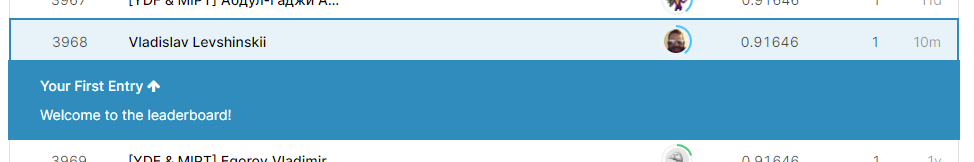

In [27]:
from IPython import display
from base64 import b64decode


display.Image(b64decode(base64_img))

Первый бенчмарк побит моделью по умолчанию

## Бьем второй бенчмарк

Попробую фичи из задания с конструированием признаков

In [28]:
train_test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0.0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0.0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0.0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0.0


### Признак #unique_sites

In [29]:
extended_df = train_test_df.copy()


def get_num_unique_sites(row_data):
    return row_data.nunique()


site_cols = [f"site{i}" for i in range(1, 11)]
extended_df["#unique_sites"] = extended_df[site_cols].apply(
    get_num_unique_sites, axis=1
)

In [30]:
extended_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site7,time7,site8,time8,site9,time9,site10,time10,target,#unique_sites
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0.0,7
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0.0,4
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0.0,1
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0.0,4


### Время переключений между сайтами в сессии и время сессии

In [31]:
for i in range(1, 11):
    extended_df[f"time{i}"] = pd.to_datetime(extended_df[f"time{i}"], errors="coerce")

extended_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site7,time7,site8,time8,site9,time9,site10,time10,target,#unique_sites
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0.0,1
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0.0,7
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0.0,4
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0.0,1
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0.0,4


In [32]:
from tqdm.notebook import tqdm


for i in tqdm(range(2, 11)):
    col_idx = i - 1
    extended_df[f"time_diff{col_idx}"] = 0
    time_filter = ~extended_df[f"time{i}"].isnull()
    extended_df.loc[time_filter, f"time_diff{col_idx}"] = (
        extended_df[time_filter][f"time{i}"]
        - extended_df[time_filter][f"time{col_idx}"]
    ).dt.seconds

    extended_df.loc[time_filter, f"session_timespan"] = (
        extended_df[time_filter][f"time{i}"] - extended_df[time_filter]["time1"]
    ).dt.seconds

  0%|          | 0/9 [00:00<?, ?it/s]

In [33]:
extended_df["session_timespan"].fillna(0, inplace=True)
extended_df["session_timespan"] = extended_df["session_timespan"].astype(int)

In [34]:
extended_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time_diff1,session_timespan,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,0,0,0,0,0,0,0,0,0,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,0,26,1,0,0,0,1,0,23,1
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,1,7,1,0,0,0,1,1,1,2
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,30,270,30,30,30,30,30,30,30,30
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,137,246,0,1,0,36,0,0,67,5


### Час начала и день недели

In [35]:
extended_df["start_hour"] = extended_df["time1"].dt.hour
extended_df["day_of_week"] = extended_df["time1"].dt.weekday

### Посчитаем кол-во заходов на сайты в обучающей выборке

In [36]:
for i in range(2, 11):
    train_df[f"site{i}"] = train_df[f"site{i}"].fillna(0).astype(int)

In [37]:
from collections import Counter


c = Counter(train_df[f"site1"])

for i in tqdm(range(2, 11)):
    c += Counter(train_df[f"site{i}"])

  0%|          | 0/9 [00:00<?, ?it/s]

In [38]:
del c[0]

In [39]:
sites_data = {}

for site_name, site_id in site_dic.items():
    sites_data[site_id] = (c[site_id], site_name)

In [40]:
with open(os.path.join(PATH_TO_DATA, "sites_data.pkl"), "wb") as f:
    pickle.dump(sites_data, f, protocol=2)

In [41]:
with open(os.path.join(PATH_TO_DATA, "sites_data.pkl"), "rb") as f:
    sites_data = pickle.load(f)

### Длина сессии в сайтах

In [42]:
def get_num_sites(row_data):
    return len(row_data[~row_data.isnull()])


site_cols = [f"site{i}" for i in range(1, 11)]
extended_df["num_sites"] = extended_df[site_cols].apply(get_num_sites, axis=1)

In [43]:
extended_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,start_hour,day_of_week,num_sites
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,0,0,0,0,0,0,0,10,3,1
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,0,0,0,1,0,23,1,11,5,10
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,0,0,0,1,1,1,2,16,0,10
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,30,30,30,30,30,30,30,10,4,10
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,1,0,36,0,0,67,5,10,4,10


### Прочие признаки

In [44]:
from collections import Counter


def feature_engineering(df, site_freq):
    def site_mode(columns, index=True):
        c = Counter(columns)
        if 0 in c:
            del c[0]

        most_common = c.most_common(1)[0]
        if index:
            return most_common[0]

        return most_common[1]

    extended_df = df.copy()

    # weekday indicators
    extended_df["week_start"] = extended_df["day_of_week"].isin([1, 2]).astype(int)
    extended_df["week_mid"] = extended_df["day_of_week"].isin([3]).astype(int)
    extended_df["week_end"] = extended_df["day_of_week"].isin([4, 5]).astype(int)
    extended_df["week_holiday"] = extended_df["day_of_week"].isin([6, 7]).astype(int)

    # part of day indicators
    extended_df["time_morning"] = extended_df["start_hour"].apply(
        lambda x: int(6 <= x and x < 12)
    )
    extended_df["time_afternoon"] = extended_df["start_hour"].apply(
        lambda x: int(12 <= x and x < 17)
    )
    extended_df["time_evening"] = extended_df["start_hour"].apply(
        lambda x: int(17 <= x and x < 21)
    )

    # время переключения между сайтами
    time_diff_cols = [f"time_diff{i}" for i in range(1, 10)]

    extended_df["avg_time_diff"] = extended_df[time_diff_cols].apply(np.mean, axis=1)

    extended_df["max_time_diff"] = extended_df[time_diff_cols].apply(np.max, axis=1)

    extended_df["min_time_diff"] = extended_df[time_diff_cols].apply(np.max, axis=1)

    for diff_col in time_diff_cols:
        extended_df[f"{diff_col}_over_session_time"] = (
            extended_df[diff_col] / extended_df["session_timespan"]
        )

    # относительные кол-ва посещенных сайтов
    extended_df["unique_sites_over_num_sites"] = (
        extended_df["#unique_sites"] / extended_df["num_sites"]
    )
    extended_df["unique_sites_over_max_sites"] = extended_df["num_sites"] / 10

    extended_df["num_sites_over_max_sites"] = extended_df["num_sites"] / 10

    # самый популярный сайт в сессии
    extended_df["site_mode_index"] = extended_df[
        [f"site{i}" for i in range(1, 11)]
    ].apply(site_mode, axis=1)
    extended_df["site_mode_num"] = extended_df[
        [f"site{i}" for i in range(1, 11)]
    ].apply(site_mode, axis=1, index=False)

    # кол-во посещений моды относительно длины сессии
    extended_df["site_mode_num_over_session"] = (
        extended_df["site_mode_num"] / extended_df["num_sites"]
    )

    total_sites = sum(map(lambda item: item[0], site_freq.values()))
    # частота сайта относительно всех остальных
    extended_df["site_mode_freq_over_num_sites"] = extended_df["site_mode_index"].apply(
        lambda idx: site_freq[idx][0] / total_sites
    )

    extended_df.drop(columns=["site_mode_index", "site_mode_num"], inplace=True)

    return extended_df

In [45]:
extended_df = feature_engineering(extended_df, sites_data)

In [46]:
extended_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time_diff5_over_session_time,time_diff6_over_session_time,time_diff7_over_session_time,time_diff8_over_session_time,time_diff9_over_session_time,unique_sites_over_num_sites,unique_sites_over_max_sites,num_sites_over_max_sites,site_mode_num_over_session,site_mode_freq_over_num_sites
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,1.0,0.1,0.1,1.0,0.000161
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,0.000000,0.038462,0.000000,0.884615,0.038462,0.7,1.0,1.0,0.2,0.004967
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,0.000000,0.142857,0.142857,0.142857,0.285714,0.4,1.0,1.0,0.5,0.000814
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.1,1.0,1.0,1.0,0.031935
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,0.146341,0.000000,0.000000,0.272358,0.020325,0.4,1.0,1.0,0.4,0.004529


In [47]:
extended_df.columns.tolist()

['site1',
 'time1',
 'site2',
 'time2',
 'site3',
 'time3',
 'site4',
 'time4',
 'site5',
 'time5',
 'site6',
 'time6',
 'site7',
 'time7',
 'site8',
 'time8',
 'site9',
 'time9',
 'site10',
 'time10',
 'target',
 '#unique_sites',
 'time_diff1',
 'session_timespan',
 'time_diff2',
 'time_diff3',
 'time_diff4',
 'time_diff5',
 'time_diff6',
 'time_diff7',
 'time_diff8',
 'time_diff9',
 'start_hour',
 'day_of_week',
 'num_sites',
 'week_start',
 'week_mid',
 'week_end',
 'week_holiday',
 'time_morning',
 'time_afternoon',
 'time_evening',
 'avg_time_diff',
 'max_time_diff',
 'min_time_diff',
 'time_diff1_over_session_time',
 'time_diff2_over_session_time',
 'time_diff3_over_session_time',
 'time_diff4_over_session_time',
 'time_diff5_over_session_time',
 'time_diff6_over_session_time',
 'time_diff7_over_session_time',
 'time_diff8_over_session_time',
 'time_diff9_over_session_time',
 'unique_sites_over_num_sites',
 'unique_sites_over_max_sites',
 'num_sites_over_max_sites',
 'site_mode_n

### Новый датасет

разреженная матрица сайтов + новые признаки

In [48]:
new_features = [
    "session_timespan",
    "week_start",
    "week_mid",
    "week_end",
    "week_holiday",
    "time_morning",
    "time_afternoon",
    "time_evening",
    "avg_time_diff",
    "max_time_diff",
    "min_time_diff",
    "time_diff1_over_session_time",
    "time_diff2_over_session_time",
    "time_diff3_over_session_time",
    "time_diff4_over_session_time",
    "time_diff5_over_session_time",
    "time_diff6_over_session_time",
    "time_diff7_over_session_time",
    "time_diff8_over_session_time",
    "time_diff9_over_session_time",
    "site_mode_num_over_session",
    "site_mode_freq_over_num_sites",
    "unique_sites_over_num_sites",
    "unique_sites_over_max_sites",
    "num_sites_over_max_sites",
]

In [67]:
X_ext_train = extended_df[: len(train_df)][new_features]
X_ext_test = extended_df[len(train_df) :][new_features]

In [68]:
X_train_df = pd.DataFrame.sparse.from_spmatrix(
    X_train_sparse,
    index=X_ext_train.index,
    columns=[f"site{i}" for i in range(1, X_train_sparse.shape[1] + 1)],
)
X_test_df = pd.DataFrame.sparse.from_spmatrix(
    X_test_sparse,
    index=X_ext_test.index,
    columns=[f"site{i}" for i in range(1, X_test_sparse.shape[1] + 1)],
)

In [69]:
import gc

gc.collect()

547

In [71]:
for feature in new_features:
    X_train_df[feature] = X_ext_train[feature]
    X_test_df[feature] = X_ext_test[feature]

In [73]:
for indicator in [
    "week_start",
    "week_mid",
    "week_end",
    "week_holiday",
    "time_morning",
    "time_afternoon",
    "time_evening",
]:
    X_train_df[indicator] = X_train_df[indicator].astype(pd.SparseDtype("int", 0))
    X_test_df[indicator] = X_test_df[indicator].astype(pd.SparseDtype("int", 0))

In [ ]:
float_cols = [
    "avg_time_diff",
    "site_mode_num_over_session",
    "site_mode_freq_over_num_sites",
    "unique_sites_over_num_sites",
    "unique_sites_over_max_sites",
    "num_sites_over_max_sites",
] + [f"time_diff{i}_over_session_time" for i in range(1, 10)]
int_cols = ["session_timespan", "max_time_diff", "min_time_diff"]

X_train_df[float_cols] = X_train_df[float_cols].astype(pd.SparseDtype("float", 0))
X_train_df[int_cols] = X_train_df[int_cols].astype(pd.SparseDtype("int", 0))

X_test_df[float_cols] = X_test_df[float_cols].astype(pd.SparseDtype("float", 0))
X_test_df[int_cols] = X_test_df[int_cols].astype(pd.SparseDtype("int", 0))

In [74]:
with open(os.path.join(PATH_TO_DATA, "X_train_sparse_df.pkl"), "wb") as f:
    pickle.dump(X_train_df, f, protocol=2)

with open(os.path.join(PATH_TO_DATA, "X_test_sparse_df.pkl"), "wb") as f:
    pickle.dump(X_test_df, f, protocol=2)

In [132]:
X_train_df.fillna(0, inplace=True)
X_test_df.fillna(0, inplace=True)

In [133]:
float_cols = [
    "avg_time_diff",
    "site_mode_num_over_session",
    "site_mode_freq_over_num_sites",
    "unique_sites_over_num_sites",
    "unique_sites_over_max_sites",
    "num_sites_over_max_sites",
] + [f"time_diff{i}_over_session_time" for i in range(1, 10)]
int_cols = ["session_timespan", "max_time_diff", "min_time_diff"]

X_train_df[float_cols] = X_train_df[float_cols].astype(pd.SparseDtype("float", 0))
X_train_df[int_cols] = X_train_df[int_cols].astype(pd.SparseDtype("int", 0))

X_test_df[float_cols] = X_test_df[float_cols].astype(pd.SparseDtype("float", 0))
X_test_df[int_cols] = X_test_df[int_cols].astype(pd.SparseDtype("int", 0))

In [134]:
with open(os.path.join(PATH_TO_DATA, "X_train_sparse_no_nans_df.pkl"), "wb") as f:
    pickle.dump(X_train_df, f, protocol=2)

with open(os.path.join(PATH_TO_DATA, "X_test_sparse_no_nans_df.pkl"), "wb") as f:
    pickle.dump(X_test_df, f, protocol=2)

In [131]:
with open(os.path.join(PATH_TO_DATA, "X_train_sparse_df.pkl"), "rb") as f:
    X_train_df = pickle.load(f)

with open(os.path.join(PATH_TO_DATA, "X_test_sparse_df.pkl"), "rb") as f:
    X_test_df = pickle.load(f)

In [136]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Columns: 48396 entries, site1 to num_sites_over_max_sites
dtypes: Sparse[float64, 0](15), Sparse[int32, 0](10), Sparse[uint64, 0](48371)
memory usage: 59.8 MB


In [79]:
new_features

['session_timespan',
 'week_start',
 'week_mid',
 'week_end',
 'week_holiday',
 'time_morning',
 'time_afternoon',
 'time_evening',
 'avg_time_diff',
 'max_time_diff',
 'min_time_diff',
 'time_diff1_over_session_time',
 'time_diff2_over_session_time',
 'time_diff3_over_session_time',
 'time_diff4_over_session_time',
 'time_diff5_over_session_time',
 'time_diff6_over_session_time',
 'time_diff7_over_session_time',
 'time_diff8_over_session_time',
 'time_diff9_over_session_time',
 'site_mode_num_over_session',
 'site_mode_freq_over_num_sites',
 'unique_sites_over_num_sites',
 'unique_sites_over_max_sites',
 'num_sites_over_max_sites']

In [80]:
to_scale = [
    "session_timespan",
    "avg_time_diff",
    "max_time_diff",
    "min_time_diff",
]

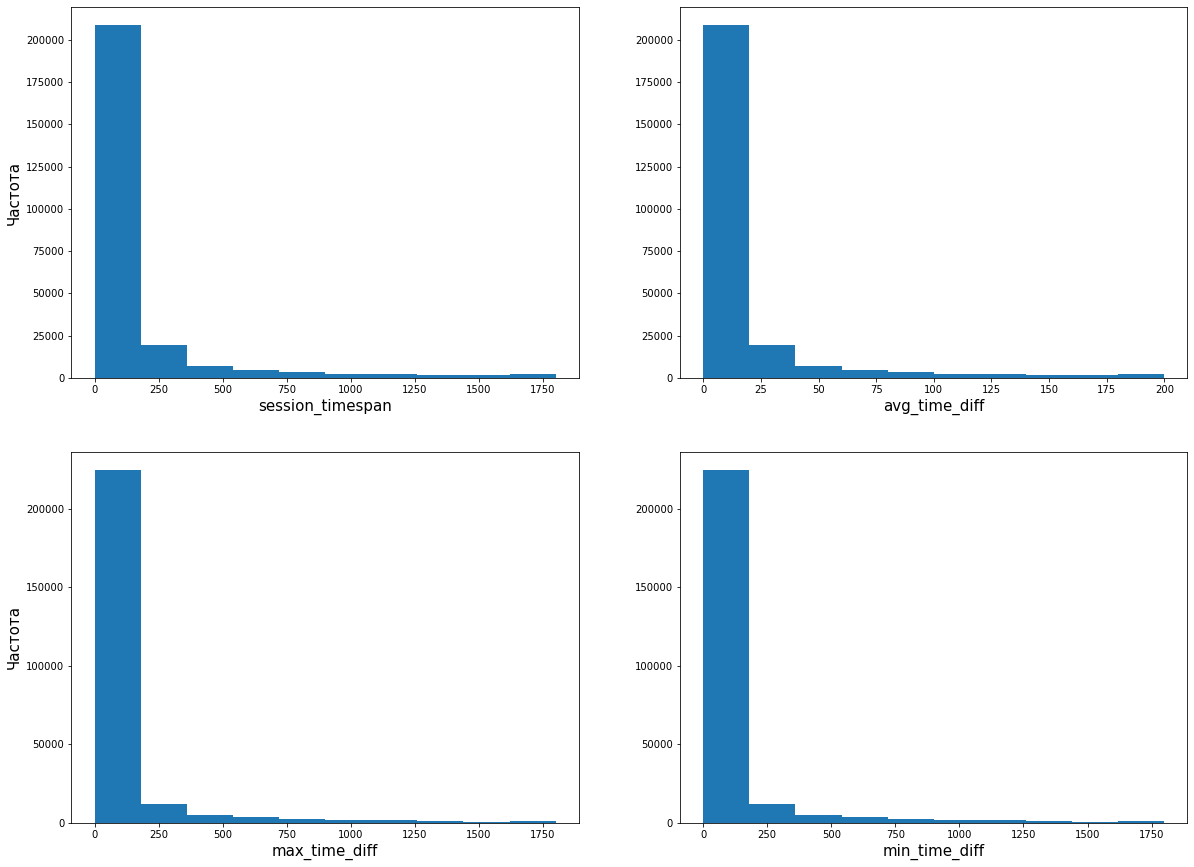

In [84]:
from matplotlib import pyplot as plt

%matplotlib inline


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
axes = axes.flatten()
cur_ax = 0

# как вариант, можно и по-другому
for num_feature in to_scale:
    ax = axes[cur_ax]

    X_train_df[num_feature].plot(kind="hist", ax=ax)

    ax.set_ylabel("")
    ax.set_xlabel(num_feature, fontsize=15)
    cur_ax += 1

for ax in axes[::2]:
    ax.set_ylabel("Частота", fontsize=15)

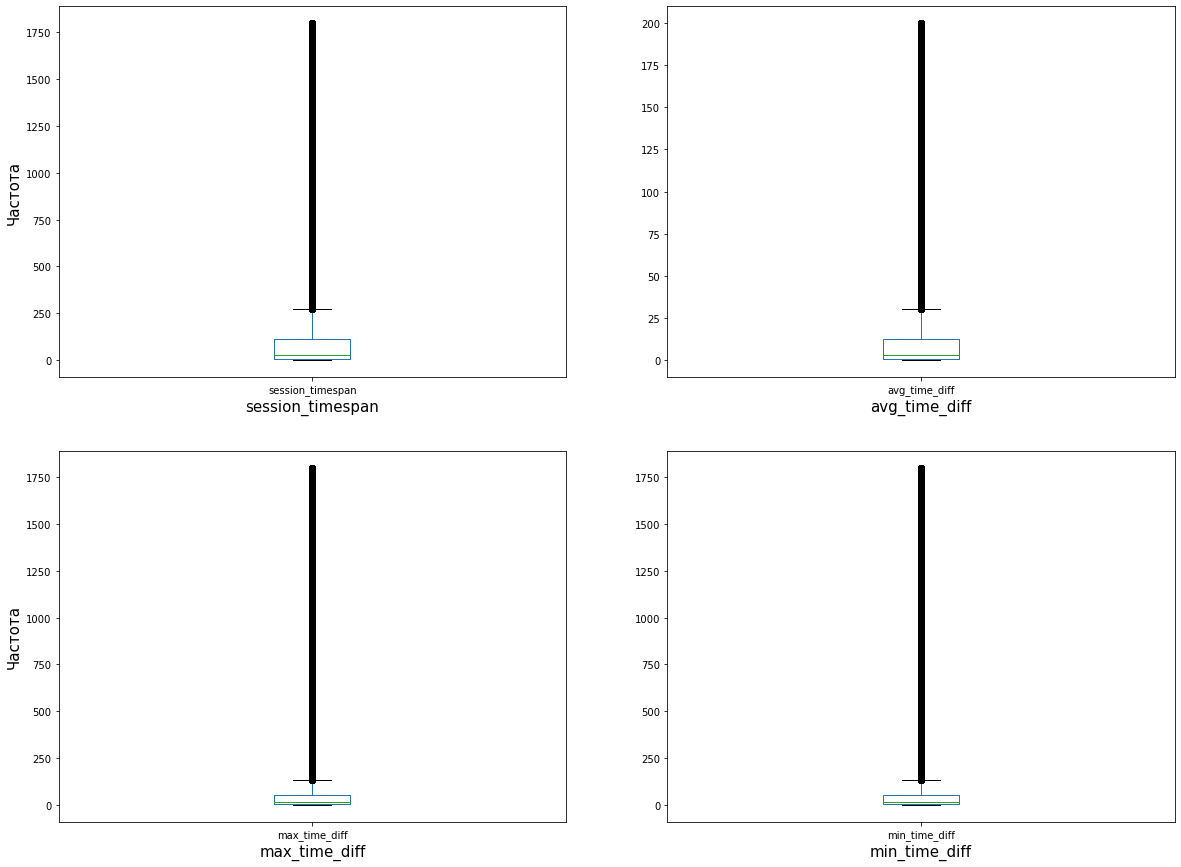

In [85]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
axes = axes.flatten()
cur_ax = 0

# как вариант, можно и по-другому
for num_feature in to_scale:
    ax = axes[cur_ax]

    X_train_df[num_feature].plot(kind="box", ax=ax)

    ax.set_ylabel("")
    ax.set_xlabel(num_feature, fontsize=15)
    cur_ax += 1

for ax in axes[::2]:
    ax.set_ylabel("Частота", fontsize=15)

Дохера выбросов, на картинках получились световые мечи

Отшкалируем с RobustScaler

In [139]:
train_share = int(0.7 * X_train_df.shape[0])
X_train, y_train = X_train_df[:train_share], y[:train_share]
X_valid, y_valid = X_train_df[train_share:], y[train_share:]

### Тренировка модели

In [140]:
sgd_logit = SGDClassifier(loss="log", random_state=17, n_jobs=-1)
sgd_logit.fit(X_train.sparse.to_coo(), y_train)

SGDClassifier(loss='log', n_jobs=-1, random_state=17)

In [150]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid.sparse.to_coo())[:, 1]
roc_auc = roc_auc_score(y_valid, logit_valid_pred_proba)

In [151]:
print(roc_auc)

0.9438220602242862


In [143]:
to_scale_indexes = X_train_df.columns.get_indexer(to_scale)
to_scale_indexes

array([48371, 48379, 48380, 48381], dtype=int64)

In [188]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, GridSearchCV


preprocessor = ColumnTransformer(
    transformers=[("scaler", RobustScaler(with_centering=False), to_scale_indexes),],
    remainder="passthrough",
)
pipe = make_pipeline(preprocessor, SGDClassifier())

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    "sgdclassifier__alpha": np.linspace(0.000001, 0.0002, 100),
    "sgdclassifier__random_state": [42],
    "sgdclassifier__loss": ["log"],
    # "sgdclassifier__class_weight": ["balanced"],
}

clf = GridSearchCV(
    pipe, param_grid=param_grid, cv=skf, return_train_score=True, n_jobs=4
)
clf.fit(X_train.sparse.to_coo(), y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         RobustScaler(with_centering=False),
                                                                         array([48371, 48379, 48380, 48381], dtype=int64))])),
                                       ('sgdclassifier', SGDClassifier())]),
             n_jobs=4,
             param_grid={'sgdclassifier__alpha':...
       1.61808081e-04, 1.63818182e-04, 1.65828283e-04, 1.67838384e-04,
       1.69848485e-04, 1.71858586e-04, 1.73868687e-04, 1.75878788e-04,
       1.77888889e-04, 1.79898990e-04, 1.81909091e-04, 1.83919192e-04,
       1.85929293e-04, 1.87939394e-04, 1.89949495e-04, 1.91959596e-04,
       1.93969697e-04, 1.

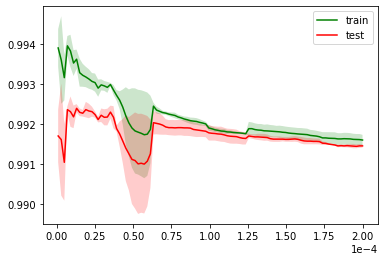

In [196]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = (
        grid_cv_results_["mean_train_score"],
        grid_cv_results_["std_train_score"],
    )
    valid_mu, valid_std = (
        grid_cv_results_["mean_test_score"],
        grid_cv_results_["std_test_score"],
    )
    train_line = plt.plot(param_values, train_mu, "-", label="train", color="green")
    valid_line = plt.plot(param_values, valid_mu, "-", label="test", color="red")

    plt.fill_between(
        param_values,
        train_mu - train_std,
        train_mu + train_std,
        edgecolor="none",
        facecolor=train_line[0].get_color(),
        alpha=0.2,
    )
    plt.fill_between(
        param_values,
        valid_mu - valid_std,
        valid_mu + valid_std,
        edgecolor="none",
        facecolor=valid_line[0].get_color(),
        alpha=0.2,
    )
    plt.legend()
    plt.ticklabel_format(style="sci", scilimits=(-3, 4), axis="both")


plot_validation_curves(param_grid["sgdclassifier__alpha"], clf.cv_results_)

In [197]:
valid_pred_proba = clf.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, valid_pred_proba)
roc_auc

0.9647407241027586

In [198]:
logit_test_pred_proba = clf.best_estimator_.predict_proba(X_test_df)[:, 1]

In [199]:
write_to_submission_file(logit_test_pred_proba, "submission.csv")

In [200]:
base64_img = "iVBORw0KGgoAAAANSUhEUgAAA+gAAAEFCAYAAABw5s2RAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAIQXSURBVHhe7f0HWBVZou4P03Nm7vn+93/Dd+93pnvuOffMmZkzoWd6pqfDTIcJPdNORxvtbjuZMOccMGGrmDCAuRWxRW0RW1rFiAFBMYAooqK0gCI0SUAREDdJwvvVqrB37dq1A6ZNeH/P83uUqtpVtatqV6231qpVPnjI5OR+p/6PkEdP6e6J6PRmJwydF4O8RnVgB6Kjf39CCCFtm9q6ety5a4GlukYdAhxPSMGcwFDMnxOGRUGbELIwAsuC12N1SCjWzF6I1WMnI7jfKMzrMxoL+o/Bwv4jEDRoHOb1H4uFvfph+/w5qKosV+cGed5iGWJZhJD2QgXS4/YhJiENN2vVQQ8Rb2ZaBnRCCCGEEOI1LDVKgK6prVOHAGfPXsbsWVJIn7sBixdtwZLgzVgRsg6rg5Zg1cQALBowCtM+HoDZPYZgqfT/Gd0Hw/8DPyzuPwD5Vy6pc4E8T/kGgLQMQgjxFAZ0QgghhBDSIWlsakKVpdohpJfdqsDOb+KwQArpwsXz12DlwuVYETAbi4eOw3y/4Zj+/gBMe68f5nw0FIfCt+BOWZn6aVs4F/MWyyCEEE9hQCeEEEIIIR2WhsZGa0gXTdIbG22B+vbtSpxOSsP2rw9h/eoILAtciEWjJ2KN/+fYvvQLnN53EOXFJerUUuCXPqs1axfzFPMmhJCWwIBOCCGEEEI6NKKWW2vuLqytq2tRzbeYVnxG+7yYF2vOCSH3AwM6IYQQQgghElrHcZrVNbWoq78nh+3m5mZ1Ksj/F8PEODGN/jPsEI4Q8iAwoBNCCCGEEKIigrf2DHlLFJ9hrTkh5EFhQCeEEEIIIcSAqCW/19AgB2/xXHmVLoyL/4thYpyYRl+7TgghDwIDOiGEEEIIIYQQ0gpgQCeEEEIIIYQQQloBDOiEEEIIIYQQQkgroN0F9PKKCkoppZRSSimltM3JGnRCCCGEEEIIIaQVwIBOCCGEEEIIIYS0AhjQCSGEEEIIIYSQVgADOiGEEEIIIYQQ0gpgQCeEEEIIIYQQQloBDOiEEEIIIYQYaG5uxr2GBtTU1sFSXYOquxbckfzowgyMyliNwOyvsSb/IM5UXsWdhmr1U4QQ8mAwoBNCCCGEEKLS2NQkh3IRxs3smjrZwY8vzMTmwmPyZwkh5EFgQCeEEEIIIUSitq7eLoxX19Sirv6eHLxFjbqgqrEGZ+9kY8+tswgtOIQB6UutQb1nWhCiS5Ll6Qgh5H5gQCeEEEIIIR0aEcAtNTXWYF5bV9ei2nAR2EdlrLEG9YFSaK+4Z1HHEkKI5zCgE0IIIYSQDktDYyOqLNVyMBfPmjc22oJ5ozTu7t27uH37NoqLi62Wlpbi1q1bqKqqwr1799SpgTOV2RiQvsQa0svr76pjCCHEMxjQCSGEEEJIh0TUkmvhXDx3rtHQ0ICKigrcuHHDI8W04jMC0QR+4LdKs3fWpBNCWgoDOiGEEEII6ZBozdr14by6uto0hLtT1KyLzwqMIZ0QQjyFAZ0QQgghhHQ4tA7hRLN2DdGc3Sx8FxQUICcnB9nZ2bh27Zrsd999h6KiIodpxTwEIqRrzd2jS07LwwghxB0M6IQQQgghpEMhmraLcC7Unjl3VnMuwnlWVhZSUlJkT5w4gbi4OJw5cwYisJuFdK0mXTyTLgK66N29JZ3OEUI6LgzohBBCCCGkQ6G951z01i4Qz48bQ7ZQhPO0tDRcvXpV7ihODDt37hxSU1Nx8OBB2dzcXIfPCUUHcwKtd/edxaxFJ4S4hwGdEEIIIYR0GMT7zK2152qttlmHcKJm/OzZs9i7dy9OnjwpB/Ovv/4a4eHhOH78OI4ePYodO3bg9OnTDp8VinkKxCvYtFp07V3qhBDiDAZ0L1NnKUF22nXcrFUHmCBPk5mPChfTaNRZLLBY6tW/bCjD7a1Xbuy2CWqki1yFkw3QfFeMq4C4B95c63w6MY9K01G18ucrzN6E0qCMs3UdY0NZrpOdon5Or9k89Oi/hzPENNnn45GcWYxapbNYQgghhLSAew0NcjivrlGu4aKmWx+sCwsLcf36dSQlJcm14xcvXpSD+JEjR3Dq1CkcO3YMomm7CO8RERHYvn27aTN3oVaLvjr/AGKKz8nLblc01uN2QQZySi2wvWzONZ6Ua5try5GXmYHCO45lWivSsouvp3mw7Hq53Otu/ZrrlfKxp9+DmCNnDhf7tk0hHWN3yopQVlWPxxmbGNC9RHPNdexeMBB9RwUg4PMATBjsh9k7MgwnBQtSNwegz2B/eZphfgMRdqpEHedI081ELOjti08XJ6BSHSbTnIHN7/rC19feXVnq+DZA6e4RePJ7r2JZqv0vvrkqHqP/fz54fV6SHGzztnyI7/2PeUhVRttoTsIMHx/031asDrBx59AE+EjjnvRdj3x1mEZ94jxp3I8wdFuOOsRGwiwf/Fv3SNxU/9ajfM7Hzn/6P79G/5B4lJpdm5tzsLqTmO5HmJ9gclaTxu8a2wlP6ub3/X/thIBtV9wGf0IIIYTY0Jq319UrpS59x3Ci4zfRpF2EchHGr1y5Ij93LkK4qDXPy8uTe2svLy+Xm73v2bNHrlEX04tgrw/nQq3DOLEssUx9b/Ftndr8WCwd5IeRAQGYNnEg+k+PwjWXX68ESaH+eH+IVq41K/tK06yzlX2njvDDiJWJuKWO1ajOiMIUqVw8SZpGWXY4LpgUyJpupyFyth98uwYhsUwdaEo5EoI9mY64ouZqFMa954veURnqkLZLZe5p7InYij0x+7B311ZE7j+Ngip15COGAd1LXIrsjclb06B0ISLlr5oMhI8eg/26HFh5OhQDZu9HkXrLpqkkAQv8/O2msWFB0hcDEbwkyCGgN91ORFCXcFxp07cEi7Ghm2OITg55BT/494k4pb5itOUBvQLRQ3zw/z73PJ79XmdEXlcHq2hB+4kfdMNOw+HlLqCLz0SkazXoxbgcMw9vPemDp/tFOtwIuJcagmd9nsfzz/ng+c/jDaG7FgcnPCkF8s4IOZYjtwJorsrB8eUD8R9Obh4QQgghxBzRa7u+ebv2bHl+fr4czs+fPy//GxsbKzdtj4+PR2RkJA4cOCB3FiemLS0tRUZGhtxZnGj2vnv3bvnz+nAuFPMWaJ3S6XuMb9M0X0fUeD9EpGrveK+Xyrb+GLI2xVq2NVJwOBCDliXgplquba7Jx+4gP2xIsb0nvvSYKMfGWqcRgf1IkK/dNM11aVjf2x+7smy16wWHgzDkS/tlV17cjImDg7A3LQFfvuc6eIsy9/ClwZjty4B+34hjYoK/lEUC2nxAb6rMQExEPHJ0rWvL0g9i29mix1KTzoDuFepRdi0NhXfUP2UsSFjxHpaeLFf/LpdPSFvS7Jv2ZEaPwXCTg746NRzDlyWiLCPKIaA3FsViSt8o5Kl/t1UastbjLSmQTt6vPNOl/T10hy10tzSgN93ciT7S8JlHkjD/tz74KNw+7MoB/XvP49VXfuRwc8CTgB5dqA5QEUH8JZNa8uQFz+GH76zHqT0j8b3/OhGJuoSuhPcfYWacsWa9FgmBz+EHP55uNz0hhBBCnFMlBWURlrXnwUXYFmFavEYtOTlZbsIuasU3btyI9evXY+7cuQgMDERoaKhcYy5q0sV0oom7eA5906ZNCAsLk2vXjQFdzFugPfcult0eaJDKm/1nxtrVbDffTcEKpwFXCtpzfWEsworyaw9dqK/KT0PuLWPZd7hd4BO14vuiU+yWLSqx5g6JtivrymVtsblFS1IXAb25Jg1rBwfj7C3X0xHXFBwIxOc7rqPwWFCbD+gNllu4cbPaLow3lZxHeNw1iFts98pycCmjxND6owK5F9NR7OwOVQtgQG8lNFUmYmXvQCSo+VHcHQw1OUk0XN7sEMCV2ndpWikpihOmcbwY9smC/bh4LhbRO6OxOy4FpW3y+lCL03NfwX97cTrOWSqwa8hTDqG5pQG9dMcAayBODnkO//0PIUhXxwm0oL09Q2lK/+7y8+qY+wvooqn6hq4++N38JHWARPN5682BpvIYDJbWc+xu5SaEIDP0dfyXH5t8Jwlxk+I1KbwvMxtJCCGEEAdEUBZq6AO1qAUXQVs0VxfN3Q8fPozZs2dj+PDhGDlyJPz9/eXQHh0djW+++UauWRdhXoR3s4Au1DAuty1TcMCsllQJ4eaPUJqPE+XaLu9HIVv924h4JPSbmX7YdsnFs+gSFadW2gV9O1wG9Hpc2jwGSxNK3ExHXCFukMwbu1l+xEG0gmgPTdztaUTRud3Yf1m5LdRcl4eEsOPI01WQ1ReeReTBDJh1adVSGNC9TNZu8Qy6PwYND8LhLNtJu+lmAmZ3dTxhibD9vl1tuHJiWRirPJtuFtBvnl6JgUMCsS46ASnnErB9ZQD6+Yfj28f0HMXDpLkqCZN+54O/dOmMZ594FWvS1BEqLQvoSrN5rUm51sxcP0990K46Pl1epvYc/H0FdAnj58S0T31fa16vNLn/yaCd0BpYuFpOc008RpvceCCEEEKIOa4CulHxmjXRYZx4Dl0E8unTp2PChAmYOXMmJk+ejBkzZmDhwoVYsWJFhwrolyL1rT41lNafqxKNwxUyt4/B0E36EC2F9mA/04B+MzlcfU7dH+Gnnfe/JHD9CKiEi+Bdnb4Z42arLQEY0O8T8RiCn7XVb3sK6M2WPCSKZ9C370Ts+SJdjXkj8k+H4Wi2djRLfydH4EjWwwlXDOheRjTlEc85ndyzEhOHrMRZNYXJAb3LZrcBXXTG4O9va9JjFtAdUUL9lF2GB67bCHKHcVIo/Xug0jGcnpYEdK2JvLW5udpR2x90tdv2QbsWxwKew//3z/NwTrq+3l9AF8+T++DH/Xaqn5P+nvykXUsA0Wmd/rOulqPVuOub+RNCCCHEOc6auDtT9NAuatZFh3FbtmyRa9C/+uorfPnll3LT9sWLF2Pp0qVyjbvxs+21ibsc0EWtsx2uA7po8Rk5zQ9DA0MRsTMcC0cMx+pvNptWSNXeui6Xj88mbMaMwQF2z5vrEfPcMt4PK0+4CPFOgndz3XVsmaAL9gzo98XN48EYqWu90K5q0BurcVP6/RflZyBx71bEXr5lbfYuasy3qk3e0ViEpAj7GvUHgQG9FSGe3ei5KU25OyOdJOQOLQypTDyrYw3gcmcMw7Htou3VaZUpm/HJglgUunlNhFlT+bZCY34kukihdOkZdYCOlgR00XRc6xFdr/6ZbmPQFjX4M//og7fnJWF34H0EdLU5+x8XKU3ltRpws/XosUm5YmRukr6T4bl0De35dDZxJ4QQQjzDWSdx7hQ15GfOnJGbs4vn07/44gs5mK9atQoBAQHyK9mMn2mvncQVxkkhbKtjE/f9Ae7eElSPsutK5VRuhcg1sfh8kevyqCj7Gp93F8jN32cPxEqHGwUGnATvzGh/TNiaZi1DW+6myGXvY3kWVLtuUU9UmipTsNIvGMcKbVkk50AQekWkSP9vXxuxuSYH8WGxyLE2ASnB2YiDuFqlhPWvj+e4zF4tgQHdK5QgeWesvEP12IVv0Wnc0vcQlmx/p1U0D5q6V6n5lmvZ33N8fZqs7jURRcnROKprPi9w+axOK8dVQBe1609Ym4vbaPj2C7wmfcba0ZoalJ8ZuR7xR+OtHtk5z65W3SxoV0nDXvL5KX7685YH9LwdI+XXxWnN6LX1XbzLtg7C0KG25+uVmn4f9NtibLul9O5ufG6eEEIIIc5x9Zo1V4qadNGR3Jo1a7B582YsX74cCxYswPz58zFlyhTTgN5eX7PWkB2NMePsO2UT/SmF+Ibiomnhsh5X46NxKsc+tIme3bVyrSj7psdG47yh7CRC/GSHWnalefz0KONr2kwwDehKbb9pGVrSsfk+MUO03DXbfkJXfQu0dirz0nA5z9hcvQRn1u5EunLPTabkwk4cyaqQm7ufLXx4/bszoHsF8Uo0PwRsTkGFep5qqkzDlvH2JwQR2Pv5b8YFtb+wO+lRGN/FddMbsybulWdD7ebTdDsFGybYnhVpa7gK6M015+Ua7v/5p5HYdOwKSsTrzeLXY+hLPnLT9MvqdVGreXaYh2jm/pYPnp6qPJduHrSVzupELbfLgP5PnTB7uxa6Y/DV7G7ya9G6LtSa5lfg6z7m87gTNx1PSp9XbjSoy3vip+gVvBMXv6tA9vmdWNb3VfhIYX/pGWPv7oQQQghxxr2GBjksV9co18/GxkaHYO1M0dRd1J5v3bpVfu585cqVci16SEiIaRN3MW+BWJZYplh2+6AEMTP8sOJwvlLZ06gE5sm6wFyTHYuI6DRrzbdo+txtUhSuqQG+KjcWC0Xv6bpyrajVHrQsFrlqNmqud5yvKEef2+jvWTgXeNp0nU3cHwrtoYm7qBGPiIjH1XItK9Wj7Eo8tuxOgy6fo+lWGnbu2o1dW86i5CG+f40B3UuIdz/GrQtAL/UuU1e/4Vi+77rhRFOPnNiVGOanTPP+kCAcznb97JL5M+j28+naJwCbT+R7dlJrhbgK6IKmm0lY8Nmv5efUlebiP8LzvUKQojvhiteaOesZXTSTf+KfByJGmt5VU/WgP7oO6Prm6mIdft91JNYdszWx117xZtrBm2iS/7988I8lWq/xtUjbMhFv/6dtnk93nojt6bbe3gkhhBDiHu15cKHWzL2iosIhXJspmrmL59BFOBdN3EVYF8+iL1myxCGgi3kKtObtQu259/aAqFyKnDlQrTH1w8z1ibr3lyu141376mvULcjaHYT+atlXLtcaatTFNJd32Kbx9R2IeRvtX6nmtNZW13rUDgb0x0p7eQa9Muc0YraGyf1MCKPi0nDToU6sCpf3h2HbeTePWbQQBnRv01jvwTMankzjCQ9rPm2D5toK+eJY215uVqvUSN+pkpXmhBBCyH2jNXOvrVPatDU0NNiFazPFq9euXbsmvyd9x44d8rPoorl7cHCwXJNu7MVdqz0XyxDLai/N240017b0mW1Py76u+1Mi5HHQWF+Peqe141VIj7Fv9v4wYEAnhBBCCCEdCn2tdmOjUoteXV1tF7CNigCelJSEixcvYs+ePXJP7uvWrZNr0kUNmz6gi3kJxLyty1Fr6wkhbZ1G1NfWozL3NKIf0rvP9TCgE0IIIYSQDkdtXb0cnPU9q7vqME40YT958iQyMjJw4MAB7Nq1C5s2bcLq1avlWnStibvWMZxA6zFeLIsQ0l6oQHrcPsQkmDV7f3AY0AkhhBBCSIfEUqMEaH3zc7OadNGDuwjgFy5ckDuKS0xMxMGDBxEVFSWHdNGTu6hB12rOBVozerEMQgjxFAZ0QgghhBDSIRHNzqss1Q4hXTyTru84rqCgQH7+XIT0srIyZGdn4/jx4/Lr1kQv7uK59Hv3bE9Ma+FczJtN2wkhLYEBnRBCCCGEdFgaGhutIV00SdeeSReIjt5Ek/Xi4mKkpqbi1q1bckAXaqG9vNz2ilzxWa1Zu5inmDchhLQEBnRCCCGEENKhEbXcWnN3oeh5vSU132Jarbd2OehL82LNOSHkfmBAJ4QQQgghRELrOE6zuqYWdfX35LCtf4e5+L8YJsaJafSfYYdwhJAHgQGdEEIIIYQQFRG8tWfIW6L4DGvNCSEPCgM6IYQQQgghBkQt+b2GBjl4i+fKq3RhXPxfDBPjxDT62nVCCHkQGNAJIYQQQgghhJBWAAM6IYQQQgghhBDSCmBAJ4QQQgghhBBCWgHtKqA/FxJHKaWUUkoppZS2Wb0FAzqllFJKKaWUUqrTWzyygF58t45SSimllFJKKW0zMqBTSimllFJKKaWtQAZ0SimllFJKKaW0FciATimllFJKKaWUtgIZ0CmllFJKKaWU0lYgAzqllFJKKaUO1uKm5O2qalTcrUZllQV37lrw4almjExtxKzLDVh59R7ii+uRXWn2eUopbbkM6JRSSimllKqWqKFchHEzfY/DwW5SaBdhXXzWbJ6UUuqpDOiUUkoppZRKlt2tsQvjoub8VlUNSi22aURt+ZHie9j6nahBb0D/s03WoN7jdDO2fVdvN09KKW2JDOiUUkoppbRDK2q+Ky22WvPbUjAXTdzNpjXzSHE9hqfagvoAKbTnsNk7pfQ+ZECnlFJKKaUdVjmcS4FcqzEv1Y0rul2GnJw0XEreg31bFiFs3ggsn9oH0WGfI/3MbuQXpONGRbl1+rjie9YadYZ0Sun9yIBOKaWUUko7pPpwXn63xjpchO783DPISI7Crk0LMOjj9/DqM7/D8z//Df74y1+jy0vPYuGId5F6cAXKvkvAnYpclFRVyZ8VTeAZ0iml9ysDOqWUUkop7ZBqzdr14Tw3Nw3px0MR+/VcjOzzPl741W/xzE+ewS///Wn8/N9+gV9J/772+2fg1+n3mDvgNSRsm4Xbeadwr+oqKqqV2nRjSNfmTSml7mRAp5RSSimlHU6tQzjRrF0blpOdjNRDC3B02wxM6t8Fv/vZr/H7nz2Dl37xLP786xfwp18/j5d++Xv8+enf4eM/PYdh776IBUP+hrP7F6Ky6DjqKlJRWV0qz0sf0tlxHKXUUxnQKaWUUkpph1I0bRfhXKg9c56Tcx7pCauRGrsMX8wailefeQ5v/v4PGPC3v2LSu50wo8sbmPn+W5j83tsY9Prr8PvzH+H31xcwu/9b2LVqKG5k7EbN7bO4V30Vty235HmKZ9JFQBe9u/MVbJRST2RAp5RSSimlHUrtPedKb+11KLxVgvOHFuNS/DJErx2Hrn97Bb4v/x0Tur6PoM8+QEgPXyzv2QVf9H4fa/p8gNV9u2FV//cREdAbx7ctRnzkPKTFrUBVSSLqLZloqM/DzWql2bzWu/u2XNaiU0rdy4BOKaWUUko7kLbac+1VatcvH8b5w8FSSF+KJVN64s0X/4yJH/fG7F59sajnZ1jeuxtC+3yE8IGfYOOw7ogc0ws7pvbD0TWTkX16K27lJCA1Zg5uf3cEtXcuoaE2B1XVefK8xSvYtFr0lry6jVLaMWVAbyXmleYj6XQGLpeZjxeKaU6fz0aWi2k080pv4/ot83E3bhUj5XwazhcrvY22JTMLS5x+/6ISaVxhpcP/79dc3bKyz23DgrXHcdUwjZk3bj34sp35KOft3kp5+39XYTZOWIJda5Zj8/mHs37uvmv64bVY9PVFfCf9v6jkIsKC1+JQnvm0lFJKqeZNNaBrz54XlZXi8tGlyEoMw6ld8zF9yCfo+qd/YIbfYMzv0x9L+/VB6KBeCB/WGxGj++Dr8f2xfcog7J8zHMfXTZWuR6tRemUfzu0OwI2sGNSIgF6Tg3vVWbhpETcBbM+ix0thXb8ubd8qXMvJwKmsYuR72Fv9jdu3cfGyVA4tdFUOVeZ7LD3fxXylaTLT3Czb9frlifKymU7K0NS5bTlfaBaUluBSTglyys3HPy4Z0L3sjVsZ2Di7Hz4dOgVjJ0/B0H49MXlLGvLtpruNw19OwSf9xsvT+PXoh+C4fN14e3MubsHgtzvjk6/SDOOqkLxnKXr0GKIuqzP6BScg3aKfpnUb9Dcf/GLCITmU6YffqErG1Gd88OxkZdzOAB/8n4834fJ9frcbVccx3scHPTYpd7/3z/whnvgv3bHluvn0es+ufx/f+++BOPIItuujnLc7CzI24S1pm8xJMB9feG0bfKXxL8xNNh3fUl1/1zys/swHP/j3QByXxucdC8S/SMvuu0XZX5RSSqkztebtt6qUJujZWSdxdu90XDm5Gke3BWK83wf45O9vYqbfAMz364clffti9UA/bBjeF5HjB+Fr/2H4ZvJwRH8+HAeXjMXZbxag8HwUTmwegysnQlF95wruWa7hXk0WKquVZ9FXXm2QA/rKq/fs1qUtW3QjBUsn9kTvMVIZ1n8IPu2/FAdzzafVPH9sFQa/0w8jpHLo6CE90WPyFiQZKl5yL+3C5L490d9flI3Ho0fPKdh4wT70FV5PQKA2jbzsOYhKt5/G3frduJuGlW91xhvvOOpYhqbObfv54kZ5EeL3fIUvIqKxeUc01n75FfZcKEGhybSPQwZ0Lxsf3hOjNqQgR/37xq00LBk2EhHptmkypZNZj+m7cPGO8nfh9SMI6DHebhqbGVg7ejxmBkmB3nByKbgUheFjpRPhTW1YPrYFdsbn+52H/dbmidVv44n/zzDsKLIfnn9qIX7t8xSmHVRqXB92QBe1x1mljtOZ2VEDulC0XDDePLlf3X3XGxXSPtFd1HO91rKAUkppW1LUnIuAXqpeX66c3YaUmLlIP74aJ6KDMKlvN/To9CYCevoh4LPumNmjO+b36oHlA/ogfOxQbBg/HGFjh2Ot9G/4jFGIXj4FaUfCsG/lEJyKmo67ZedRZ8mSAvo1VNcoZayt3ykBfWZ6g926tF1vY+/SnpgenW0dlnpwAbqPi8I5J9ftwqsxGN9zAfZZQ7IU7LbPgd+KRFs5WArNq7qPxNrk29bP5ZzdgEEj9fPNR8TUnpgfayu/ZiVtwOBxUlnZOk3L109RlKNHOtwQoM5tD/ni0ult2HQi11pBeuP2Nez5ci+Sih2nfRwyoHvVKnybloLzdjv/NnYu7ozZscXq38XyQb76tP2J4uTXI9HP5O5eavTnGL8lQzoJzTEE9CocWv2uw3y++040H9KW1fotuLgWr0khcdSOErvh++f8Hv/thYVybar42xjQb1TkYXf4cgzp9Xf0HrcQKw4Ya1pLEB+5EH0+/ACD529DYol9QE+PX4tZ83cj1WR+XQcvxLoTtvVxDJYlOLVjLUYP/ECadqrcLFtpKl8pLzMw5JDdjYSCi7sxa95y7DGprfckoBcVXkTY4nH4rFM/jArZhKNqs+/C3OMInrcQX57WB1nRLH0h5kYoTcXFsNT4TZg7ph9e6zYMczYmW5v1awF9dpz9tjplvVmSiU1zF2JVgrIttG126rvjWDx5GN6T5jdXbZKuTN+y7VhUkoyV0vpr63QqaiFmq48dFBUo3y3qkm3elFJKqZmVVdrz58rfF+JX4UJsMC4eWY6zB5cgcORnGO3XG0s+n47lc2Zh+bxAhMwMwMrpUxE2cQxCx43C6lkzsCZEuqZ+sRTRW9bh5MFIHIpchFN7l6CqNBX1tdfRcK8AtbVKOeKI2pv7iNRG63LbsoW5R+D/bhhO2DUFzkDosJ7YeFE/zGbq/jn4eIN92fXG7RQsfGcV4tVwd+N2MZJOZ1sDu7CoKAEz35mDfWp55sbtbOyOjNEFQmmYFOyD31mKQ2qZ+n7WTygqxXrNO4Isk3HUzPaQL6qQfHg1dlwq1w0rx8k9q3FUvZl043Y+TiRdw9XbJTh9Mg5bDp3AqeviO1fhspTldu+Nw4ELuchVK1MfVAb0VqY4Cc3r8Tmis5W/lROX7aSkmX92A7oaTiCiZn3KiA1yU6HLDgE9A6u6S/PJvY3zJ2IQHhmFjfsScVl3cmsb5mHp+z746dDd1uCoNW//W5CtabU+oMvjX/DBj//WTwp3u6Xw2g/P+Tylaw5dicjx/4Hv/5+/w2/qQsyY3A9v9u4uh1EtoNuHRdG8+kl5fou+PmSdn3bTwH7aEoQPeBL/5ecfYMzabdgcPhV/+6EPOs1NloPq1X1T8cN/egdrLivrLdw/3/5mg153Ab0gfRO6/IsPnu42Dks3bML0vn/HU//aHeEZYnwmgv5hewxATF9UsBu9pO85ZJu67ps+w5M/+jv6hWxD1Nbl+PQPPvi1uq21gN7prQ/w/riFmDVvnPxd/ucryroaWx2IdfX53st4SZp+pBSeR0nrIpqh21oleL4dRTif9vaT+GXvTdabJPp97EntPqWUUioU4Vwf0NPiliH10EJcjFuOxN3zEBwwAMtCFmD7N1tx5OghxEruPbAb0VGbsX7mFCwcLF23Pp+KRUHzsSZ0NfbF7EFiUhxSU4/iTNIeXL9yBLXV11BfnSV5VV6GeCe6COjdTomO4hzXqa15/VSYQzlUGL/uXV0lk70ioBtbd8rB+q3OrkNznGhJGuOyybSoxdXXst/P+rH2/H5sH/ni2sUYrE24Zq1BLyr+FlEbj+G82lKzqPRbRK6MwY74Uzh9NRfn004hfOVeRB+KQ9yVXFy4molDuzZi06n8h9IsngG9lXgySnnOpuegOdh2wdasR74D2HkLThtOSvmpW/B2ry12zX22ze5pvYNlDOjyczbvLMXS0CmYsGQX9p9OwKbgKeg+NgzHvdR84369tKWfXTN3pXn7c1h02jaNXUC/lYfDMYdwSneTY+ckH/x7721KuLu4Fi9LwXDiPlvN8tVDU6V5mgf0wtxt+FgaN+2gbX7fJh9CvFrjrZ/2RkUJEo7uRvwV27Qn1r5vfXZaDrX/ywfdwjLlcdabDYvMn+N2HdDFjYYf4sd9t1lvXogbBKt7+uD5Wcflv8Xnf/DvU7FPPeFc2jZMty2VaX8lBXhtnoXfXcTOJGUbaCH4w9XKugqVGwx/l28wmAX0J76vv/lQiQ1DbPvF4+14NxPLpCD/0/cW4pjuMQMGdEoppfejMaBfjF+BS3ErkHp4GbaHTsRwv48wfNAgjB4+CrNnz8HmrZHYuXsXVgUvQMioIZjTqxsGftAZH7z5Dj794BOMHTkaWyPDkZR0GCuXB+FAxFLcvXURdZWpqL9zQV6GFtA/bCcB3bEiSDE+/F3035LhMFwoQvSAXmHW2nKhaHb+0TtmAT0DGyZNwZgx/TAwcJddbblR8XjoF6N7YvkJW/n5ftYvM26paainzm0/+aIKqUl7sV5+Bn071mw+hBP5SieSQiWgR9s1eT+fsBpfnSmy/l2Ym4zVO9OQrf79IDKgtxKvZaYg/nQKdkctxVBdJxZKQN/gNqBfPrwA/XXP8BhPTEUliZj7VmeMk4bZOqCrQvyXIzH6a/MTVWtVC3Zare/OgB/iX95ca61ZVYbZwpsyrBJXUo9je8w2BM8bh7d/ahsvao2/91/HWUOrUITNYYawaQvGSs2vqBUXTci/Tsq069ncLERf/zZZWvZu6eI+FZ/+9Sm78aJ5/g/fVdZfvtlgqFHXazZvTRHuRdh/c9o2aVmHrK6Y8LIhFGvP6ovaffsadbEt/sXnJ3h/3HKERicjRReIzUKwfphZQDeuq/1+cb8dn/jBB+jW/Un8P7+Zir2GPgAY0CmllN6PxibuKQcWIj1+FU7vDULYrCF46TfP4ZVnX8RLz76Ct//xLgKmTsOalSswrm8/zO/dA6FDemJE50547fcv4G9/eAVd3noTAZPHInLzaimAfoyouaNRUXQatZUXUVP1rbyM9tbEXZQzjc3Vha4CsCh3Hv1qCj7t/zkWh0chZO4QDFq8BctmmgX020iRysXxUuDbuHC8i07H8rFtfk9D+fZ+1k80f2fteUttL/ki81IcQrcdw6lrJcgpLcH588ewYVMcUtQbQ1oN+hndjaILJ+ybxcvTrEp+KJ3jMaC3QsVz5B+FpcgHuvJMjWg6Yj+NvulOUVEi5vVYgJ1ZttdDJEfPwUdfJkr/V0408h0ukyZEIui3vbuFlYgc7aPWFNvXQGvqw1tR8XFM+IsUBP/zZfn589lrt2F2H11ANwmS7sKm8uz0QvT54O/4+ZM+cvP4OQlKDbz9tJlY0/M/8E8/ehpvD56KQCmIrpj8d7t56UO5aN6uhXUxzqjZumpq6/yHnlMxa55ogm5Te1ZbH8pz5ebtto71NMUz6NMHfoBXf/0UfKTxb885Lgf4hx/Q3W9HH2l+L3/4gdz0vc8m5/uYAZ1SSqmnGjuJOxcXitRDC5C0Zy7WB/TDn375O/zxty/gL8+/irdf64R+3btj/KBBGNu1G5b07oUtI/sg2O999P7rX/DOy6+i21udMKD7B5g6bgCG9+iCI8v9pYB+CvVSQLfcVTopa2+dxMmPWs4+YggjyvPIzpuQK4rnk0WllPKMcj42T3J8lNPefERMceyPSQzfu2K8HA71z6wLW7p+rD2/P9tDvrhRmYu9X0bjpKED6itnoxGWpNSQM6A/IG0roOdjv+jkwtAExP65mdvYuaAzgo/Zmu0IT24ZiTHfKHemxI/A7BURwjff05rHm3c2J05IH+pq3tuKctPqf+6H9VsDHZ7hFurDmxwU/9+p9kFxkm18XpyYh9JMWxuvdUbnPKBX6jo7y5SfizcL/GLeohZYeQZcUTRxtw+umfLr43ps3C03b9eWaaZZ6LWpPJ+vfxZfeMPw3vKsXePkJvYRkcPkf43zytW9+1Osq1j/DVcfVUB3sx3V/XZy/WcO+5kBnVJK6f1ofM1aRvoxpByYh/OHlmDf6in48Pcv4pVnnsdrz70C39f+jj7vvINBb76HMe90w9JevbF1dH98EzAIcz99HyPeegvDuryN0Z+8i+kD38fMXm8hOXIe7pacRt2dC6i4Wygvo729Zk3uuO1dW6dsikottPlbhsRrgI9g0+EMu5pu0bP7hBG2Z8cLryZiw25j4DYL1lU4umE8ei80hnDFlq0fa8/v37afL5RgfQKXDB28iefSlx9RnktnQH9A2lZAV14BMfbLRGSpvUyKdzZ+MVrfi7sS2LuP3YC4QuXvrLNbMPhd13cbzZ69Mc5HvENy/jDbc+ttyRs3D2HY//bBk089ZXjmWlEf3uTnrKWQueaSUjP77am1ckdq2vgbN49jghSMf9FrLeKvlyAjOxkLe/6HXYdm+rCphPen4Lc+Uw6Xonf0aW/44Dcjlc7U9NNqz8dP3ac0x7+esRvDX/RxCK7i9XH/JH0XcdMh0sV+FfN+Qpom+ICtCbsw+rwyf/Fdn/w/7yDwgNJc/Hq6sjx9aFe23VPStjOGeaUTOdERW0qZCM8liJ7/Dr7/b8oz6g87oLdkO4p1E8+h/49XAnFYberOgE4ppfR+vHm3Vg7ooiZd/F1wsxin987BhcNLcHj9JAx+7c/o+ZfXMegf72Lk210wQvq37yud0O/Pb2PCux9i3iefIaTPJ5jepTMmvtUZ87p/hNCRPfGVfw9M+fgfuBwfhupbqai3fIublrvyMvqfbZIDenxxvd26tF1FaFbLsHKwuS0HZn2taWFOCtaHx8hlCvlv8djmO+Ox8ZxS6VRUmo0t8/shKM5W5pVbhXYfj7Uni61BPivJWO6tQnL0AvRzEs61adytnyZrzx/Mtp8vbuHYjtXYdjof+WpILyq9hn1fb0TMFeU7MKA/IG0roEuh5lY2olZNkTvIEDXeb/ccgrk77O8uyieiPUvh10OZ5p3+c7Dtkn2NulHzzjGqcOZgGEZ115Y1BasOZxuW1XYUz56LJtDas+j242zhTYS7NX1+JQduMf0zfTZh0Rj9+Dpkn1uLT54WTbqVZtazj+12GTZPRY3DK08q8xM+/dFyawdm9tNWInrOO/i/6nQ//vtUBAd94BBctYBpdrNBr5i3tky9v1E7gRPLi1vdT24urox7Cv8Ysw3nKu3nI2+779l3rCcskAL9wL8q20Eong9fqr6W7WEHdPG359tROvGJRxVe9MGvhyid+zGgU0opvT+VgK48h14rD7t0egfOH1qMfWuHY3TXN/DpK3/F2LfexcC/vYluL/4Jbz7zIjr95gV0euYPeOv3L6HLiy/h/Rf/iPeeexmfvfoXzO/ZBaEj3kf3Tn9C8qE1KM+LR0V5ujzvI1IoF+G8R7LoIE5ZXntQlGG3BA+xlmH7zt2Fs7oAcz1pAz56dzyidB3lXr24C5P7qq083+2HWQ5l3jrkZhzB4ok95WmEnw5dgKh0W9iTg/7byjij+qbW7tZPkbXnD27bzxc3bhchfv8WrFy5Goslg7/cguizRdYe2RnQH5C2FtA1b1RWWZ8Xd64n03hmXuntNhvM79eikhJkFdo/b200t7DErqMyd4rps3Sdyznzxi33y364ViKzhd9Fryfb6mHq6XaklFJKH4ZaM/fbulr0cwcX40jkFAzv/jZe+eVv0fXFF/D6b5/DS7/4Lf74c8n//C1e+Olv8Mef/Q6v/uJ3+NMvn5H+/Q1elv599/fP4oOXn8cLv3gGs8d+gh1rx6LgVqk87+GpSu35ttz2Untu743bt3Fd93icJ+Z5UA69cavl8zXzftaP3p95bTxf3LhTjbzbtt7bvSUDOqWUUkop7VCW6GrRS9VhmRlnsHHRILz75xfx7H88jT//8jd48T+fkYP5a796Dn/9+Qt469k/4ZO/vgPflzvh9V+/gDd/85wU0H+H5376NJ772S/x9L//Ar5/eQEHDkTL84xTe28Xtedimfp1oJRSMxnQKaWUUkpph7Psbo0c0LVn0YVh69bjmf/4DX7941/gmR8/jWd/8gxee/pFvPX0S/j7L15A15deQ5+3fNHzT53Q4/d/RPc/vIpXfvWsFMylcP7jX8n/rli1Rp6XePf5APXZ823ftc/ac0rpw5cBnVJKKaWUdkgrLUpT93IprGvDvtwYiV/+31/hZ//6Cylw/wp/+Pnv0OWZl9BHCunDf/MSxj37CvyffRkjXnoVvs+/gBd+8RspnP9SCvS/xroNkfI89OFcdBCnzZtSSt3JgE4ppZRSSjukotl5pfpedH1IP3s5CyOGjscv/+0X+PWPn8bzP30Gr/7n7/H6T1/A2z9/CW//5g94/Znn8OIvnsGzP/k1Rg0bhzOXMuXPGsN5jqGjVkopdSUDOqWUUkop7bDqQ7po7q49ky4UQT1k6Rfo16s/XvvjX/HMT57B7376W3R6+TUM6D0AS5atlqZRgrlQfHbVVeW5c4ZzSun9yIBOKaWUUko7tHJIV5u7C5Xe3VvSqVut/Bnx2aLKavinNTKcU0rvSwZ0SimllFJKJbWO4zRFjfqtqhqUmrzbWAwT48Q0+s+IeRinpZRST2VAp5RSSimlVFXUpmvvSW+J4jN8lRql9EFlQKeUUkoppdTBWtxUw7qoJa+ssoVx8X8xTIwT07SsOTyllDqXAZ1SSimllFJKKW0FMqBTSimllFJKKaWtQAZ0SimllFJKKaW0FdiuArr2ZSillFJKKaWU0rasN2BAp5RSSimllFJKDXoDBnRKKaWUUkoppdSgN2BAp5RSSimllFJKDXoDBnRKKaWUUkoppdSgN2BAp5RSSimllFJKDXoDBnRKKaWUUkoppdSgN2BAp5RSSimllFJKDXoDBnRKKaWUUkoppdSgN2BAp5RSSimllFJKDXoDBnRKKaWUUkoppdSgN2BAp5RSSimllFJKDXoDBnRKKaWUUkoppdSgN2BAp5RSSimllFJKDXoDBnRKKaWUUkoppdSgN2BAp5RSSimllFJKDXoDBnRKKaWUUkoppdSgN2BAp5RSSimllFJKDXoDBnRKKaWUUkoppdSgN2BAp5RSSimllFJKDXqDdhXQu+xKx4iDl9At3HHcG99cksalo2eE47hHobY8m+br9WhNRPd9+nWw2f+bRJPpveySC1j0bSmiTl0wH08ppZRSSimlj0lv0K4C+gepVaiT1uN27lW74S9vyEXqPaC5rhyTg+0/86gMKmhQNoodTcjJvoo/mUx/P/Y+UYDt3+ZiuMk42SVXkVivLtrA7Tz7beRK/zPF+ObiVbxvMu6hKYXzr25q26wB51MZ0imllFJKKaXe0xu0rybuS1KxrVysSQ127rQNn5YjUmoTkpIeX62xEtBrEH1Aq7XOxoGKJmU9Tpp/pqUqy7BgnbObDmpAbyovtas9b2kNutimj/TmhhTOw24Yb2gwpFNKKaWUUkq9pzdod8+gv7a7FPnSulSX5sk11drfNbeKrDXA78TkIa6kBpX1DSi+VY5N8Wesn3/9YBFSyizYrQvRbyWWIvNWJTbGSH8vyUaMNP70pWyszbVI86jBgTjbtJpm4fmNhHLckYZ+e8k2TL8uucXlCDuiD86JGJNcipTyemV8QSnmRCvjFmdbkFcrzUwK/MW3pPVJS9d9TlUL6LeLHMepjrtcKX23UoTEFSvLqatHRk4ePhHjl6Rja6EFpfL9DWn50nLk7WKyDQ6l5iLupgUXrtjXzIv1zCwuxljdMDtNw7kGQzqllFJKKaXUO3qDdtlJ3Pw8EfgaEJ9wButuiVprW416lxNKSG6uq5GCqQVXq5Va7fMpSjA2C9G+6RZlfkelv5cU4Zr0F5qa0Fwj5lGJbR4F9ERMyK4RH7TWoOvX5Ux+ubouYr2Vdel/2SI32a+4XY59WeXIE0G5oQpL1z+8gK6sZxNqxQ0A6/ZQm8A7Degm2yA+FbsqpO9SX4kZ2ndekof0Zmmy0gLzZv0uw7kGQzqllFJKKaX08esN2mVAf3mDEkyb6xrkgHsj+4oyboktRC6QQq4y7Ariq6VhljL5WW5PA3pTZalSy+xEJfhCCr4i/ErK9wzqcVoLm9q6qMtVhinrIgK1CLRfldkH3td2ZSPiUi4GqevuaRN3EaSt6yFrq/XXArq1+b8Umg/cFdvO1qTdoYm7k23wkX47SX+/m1ol/Q2cT7FNY9UhnKvbSKW2QblRoMCQTimllFJKKX28eoN2GdCFWodxIlhOtYZxJVhWF+XaTTtRfka9Bju/8Tygu+tkTQm+9Uj+thjbZctwWdRON9UrNeTqfGpul6njFU9WNFnDsFaDXmux4ExuEYIPp9rVRHsa0Jvr6+XWAjbV5vrSNGbzMAZyZwHduA1e3lAg15hrw9fdEsvW1ajr1LazQhOuZ2Zil9x/gMKV9Ez1mX2VhiqEOPuelFJKKaWUUvqQ9QbtNqCbhkgnwfLjK6LpuRTA4x52QLcPvi9vyMPle1IcvV2EP6vzUZqI68OzBRkFRegvf0Z9Bv1Og7V2udliu+HgaUB338T94QR0sb5f3VSnXaL0nF9dkG2YRvHlDVoAV8K5uPEglqMhtr9+mhsPsfd7SimllFJKKXWnN+hgAV0NrOXFuleGKaESTUoNrRbQr6fbOmsbli1q2B88oItnuuXm9DXlGBuirovh+ezOW2wd1ol1+/Qb299D5RsJtpsHrS+ga83aG5CQVYk6bZsZprF5Br132b6fMaCbTUMppZRSSimlj0Nv0LECuqT2yrWcq9lS8LuA6Rcq5UAumr2LoKw100ZDDQ4mZ2Lh5SrclFtaP2gT92LElYlhts8q69KAK+nZ6CkF8wGnSpHXqIZ29Rl1NFjw9aEzeCk8FfO/U9Y99YyyDKVpvng+O9P8tWlaE3dLpV0zeuG646nyNJ4EdNFUHU012H0yHT0jxHxdbIMl2XLNucDu+XoPNA/olFJKKaWUUvr49QYdLqDLnZMVimBro7y4wNrxmnDwhSrcUR9/bq63IPLa/TZxN9DUgJw89RVmQpN1qaksQ6AIwdL413YV4LLd6Cbk6Jp6/2VHHs6p45tK8qzLtqoGdDO09fckoL+RoNw4ENzITne7DUKKlI13I0ftnM9DGdAppZRSSimlrUVv0H4DuhtFjfSgg5fQLdx8/ONUWRe1dtpk/BvfXMKIgxfwD5NxrdFpck2/0ume2XhnhlhvajTgqO499JRSSimllFL6uPUGHTag04fvGwkF2JdViVIpZ4vn3m3P+VNKKaWUUkpp29IbMKDTh+a07Br5PesVt0utzfQppZRSSimltC3qDRjQKaWUUkoppZRSg96AAZ1SSimllFJKKTXoDRjQKaWUUkoppZRSg96AAZ1SSimllFJKKTXoDRjQKaWUUkoppZRSg96AAZ1SSimllFJKKTXoDRjQKaWUUkoppZRSg96AAZ1SSimllFJKKTXoDRjQKaWUUkoppZRSg96AAZ1SSimllFJKKTXoDRjQKaWUUkoppZRSg96AAZ1SSimllNI26ttfJSMyvQi5FTUovlv3SCUPl9qGJsRk38R7EWdM9y31vt6AAZ1SSimllNI2qAjnjyOYa5JHgwjqDOmtU2/AgE4ppZRSSmkbVNScmwXpRyV5dIiadLN9TL2rN2BAp5RSSimltA36OGvPheTRIWrRzfYx9a7egAGdUkoppZTSNqhZiH6UkkeL2T6m3tUbMKBTSimllFLaBjUL0Y9S8mgx28fUu3oDBnRKKaWUUkrboGYh+lFKHi1m+5h6V2/AgE4ppZRSSmkb1CxEP0rJo8VsH1Pv6g0Y0CmllFJKKW2DmoXoRyl5tJjtY+pdvQEDOqWUUkoppW1QsxDdEotKq3G1oBrXSj3rDZ48Wsz2MfWu3oABnVJKKaWU0jaoWYgWXvq2GnkmwzVvVNZgz74qdN5ShddVB8RYkJpbjZ2xd7E9q9b0c+TRYraPqXf1BgzolFJKKaWUtkHNQnTx3Wps2l6FYYctyK40G1+Lo4dswdzo1AQLTmfUmAZ8d9RZLLA4tV6dqi1QL69zfaP6pwMWpMfux5lCz76Tsl3cT2u2j6l39QYM6JRSSimllLZBjQFasRpLtyph+4MddxFfYGy+bsGiCMdgrvle1F0cLdVPb9M15TgS5AtfX3O7vB+FbHXKx4cF36WlIfeW83DcXF+ObGmawjvqAImmmwmY/Z4vdmWpAww03U5EUGdfjNhxXR3iCguSvngPny5OQKU6xBlm+5h6V2/QrgJ6l13pGL4vFX8yGffGN5cw4uAF/MNkXGtTrOuwXWdMx92vg1KKEXXqgum4lviw5tOWfSk8FYM8OJbEflx4vggh8Z4dd112ZWLZpQLM3Wt+DD8Xkoju+7IR/q2rac6g39FcbD6fjf7fJJqMj8OrWy4g4EwR1p28hG7h9sNHHEw30X66B1VsF2e/U+HLGzKxIasAE9abj9er7IsWrN+SC1jzbTHmRJuMe8x2jivAnouZTrcDfby+E5OHuBILMm+VYVmk+TQdUR6nD+6rWzKxs1AcW5XYFmc+jdDZudmZ4vw39FQBNidnomeE+TTOrkOen+/dX1NafB5WFZ8bIs074lIuJju9pj1+W3rMe1JmE+XTh12u0zQL0aKGfM9e+9A9KuYuDlypQV5lHYoKLJiqG2fvXWzNNpunojv0NeinN76HTxbEotA6zAs16M0Z2PyuL5aeLFcHOGIWxt0FdEFzrQX31P+741IkA3pb1Ru0q4D+fnIl6tCA+KP2w1/ekItU6Rd0O+9qmyhkBBU0oOl2kem4+3JJOg7clU4kVaXobzbeUx/WfNq4bySU4w4sWBdsPl4E6fk59dKxCNTWN6GuSdpmlnJMdRY4pdD4dZk0kW76mqoyu+lf3nAV8XekEU1Ntmkq7ad5bVcRrommWA3KNNLEyMm2P+YHX6iS1l2dpkH8a8EGNaz6plvEGBMcf1MPoji+m+vKMdnJ9ns3pUradk1IPWM+Xq+yLzxfv9cPluKm9I1uXE03Hf84XVcq7aOGKoQ4PY6oJ75+OBffXLyK903GeeySPKRLv50KKZzvyCpwemx2RHmcPqDqdbOmqhJ7s4qwaLvJNJKuzs1mdjlRjpviNK9NL50Hz6fqb55L16E8JQxZr0N1VQhtwfnek2vKoJRy5MlNgFt2nZC/rzxLbd7iOlmJ5Y/65umSVMy5WIzgQybjVFt6zHtSZtsmZcOHWq7TaRaii+/WoDDLgomRZgG8Cp2/rkJXk+GaewvN5qnYEhxDaT1yT0Rjd1wGqtUhTZUZOLwzGkel9dUoSo7GrgNp1s9V5SZib/hKzFgRjgMnrls/q9F8Nx8n94Rj+ecrsWlfAnKrtOHSvHeE4nMpaE9YuhnR0Sm4pYyy0liUgp2bgjFSmmZuqG3drAH9igW5idFYvTAI66ITUWhdzRIk77Bf7yppXociQjFfWo+v4lJws1YdIcGA3nb1Bu2siXsi1t1qkk7yZRiuGz5NCkvN9ZVY4EGNXGvwoQd0+lB1F9C10Jh0UrlbLsL1KekkXV2Ua3qDSByfojD29X6ldsJs+pAi6biusYX8VyPzcPkecP1KqjIfqdCxq0IqBErHzSfqZ0QB7o50MYyJUf7+606psNUsfSY9XZnvkgtSoaFJujiWWj9jdIAoxEkFlaUP8bfjLqC3xJYGdNr+FEHjgY+nJdJvg8cRfRQuuYpE6RT/7SWTcaotPTe/vEG5oXQ7L9taKz5E+h3UoQY7dyp/v5WoVlgkqLXe0jzFNaKpJM86H6N253sPrikh0rkcTQ24+J24ueD570epTJHC/tVM6/q/uiUb8Xftr3OPRA/2R0ttnQG9GmHbqtBNCuJmAdy1d5FkMZunYkswC6WVp0Ph2zUcV9SqZ/lvX18Mj8pQBkjB98hcX0zZpTQdLzwWjF6+A7FoYywSjkdj2TQ/DFqWYA3aTSUJWNDbF8MWhePI8QRsXxkAvz7BSLz5cAJ64KwgadnRiN4ZjhnScrpNikae+KChZr7mahTGSeu5eFsCUs4lYONsP9u0EgzobVdv0O6eQZcvdNKF63q6cif5td2lyJcuBN+mqUFGUmnKWIPK+gbkFpdhhRqMhOMuVyKjoMiuhnhxtgWn05Qat9cPFiGlrBQhccVIudOA6uIC63R634nJxf5CZRkltyux7YhtGWJ+V65m26Zfko6thRbsPqn8rZ3sB6WUIetuAyqqLEhOt13InluSjZiySmw6konoknpU1tUjIydPuohekOZdibyaBhTfsv9e9stMxJjkUnn9a8VnC4rtmhO3ZN21pnuldeq08bYmXNq2mrNL2t5ltvUc5OLiK+a3NV/MrwkVlVU4eMa+Ob2rfSe+19jUMlwS36umBhcNyxL79srVXMy4IrZRE85fUIa7+g5C/fbIlbbVNLmQ4jygryqWClblxXY1eh9eqJLO9iZ35KVC0IE7SusO/fC3RQFGm35JCmZfKMa647ZjWCgu+NbPGY4hZZh9QWTg1Rr5RtUM3Tp0OlyGm7oCl53q529kX3Ecp7OndJxm5ObZvq98fFpwLMW2vv1Sy5GRV4Be0v+1gL5aPb7FvhLHt3YzQjluKrHRuk7O96sW0I+eVY8xdR85bR6vrpttO53B55fLresh5u3sZoWw21Hpd1+mHX/lCNP9NpTjK9vud3vonFrgNtHuXNPS37Q6/cZD4tg1/z04O1e5Ot5nXKlCRrb9jaTXD4v5lGHZ18rfrn6DyrkyU56PmL9YZ1EjNiBROd+YbZMHOYeIbZglFepFSMi9ZTj+7XR+DL0lrVuWNG9R7Kwotzic/4V/jhLLl7b3Qf3wRKzIseCCdOwqf5+Rzy3Oz9n266d9N+33qGy7q1ibK7ZFDQ6YNIU2O8bMrg1fHVe2V0VlGcbK45x/f3f73O44lXV9nnV3fROfd3X9MerqeuRuXVzuE0ln29z1dcZRZ9Mr+7hGrimukZafecu2v/W29NwsXx+kML5F/13Va8mNbKWsIo5r47Hs8maW8XzvwTUl9FoZAiNaeKNUmm+8lH7Mblj/dWexVF4T81e2n3K8t/yarY0XnxHliGMX1OuL/Puw7Q+z37qwpce82zKb5OMP6HU4G28Wvt375l5p25nMT7MlmIXS5rspWNHZT206Xo9z69/D9FmB6DtOCbP68c11aVjfyxdhybZa6qbKRIS8p/v8Rj98tjJRV6tuQcLS92yB/wGbuC+MLVGHSMfthc3o1SUACcXSH4b5Zm4fgE/mxVpvADTXliAjs8S6XgzobVdv0C47iRsmXeyUu8CpctNhEZa0QvcbCdJFr6kJxQWl2P5tsXThFwUz24XFrHZPH4SUC1ETai310km6GFHJjuFFu7stmkuuO5ktXeTqUatrruZwojZc9JR1aJAuPhYcltZxR1YlSht0TfTl2p4mVFpqcCFTjFeaxom/c+XvVYpz4k607nvol/lBqmhC3CAVdAsQdKpInla7S96SddduhohpxbbcKRVyxLbRboZoF+2KSimAZdm+R3VpnsOFWXbJFfnCLZoCRiVnY4VUeLojFby1GgBl39mWFyMFGTTVYKtaYzD/O+nvhnp5WdZtUGPbBvJ2rW9CiaVK3q6iiZvxO4iCYJ20zKQkZZlaEz/beCkkSGGpzllAVwsft3O1QrviyxtEwcOkAKNNbxbQxfROnldU1ksqsKQ4LzgaC3jrpKtG0y1DAcFw7On1tPZc2c8WrFenU9ZdOU6U/ZwoHzeiQCbGi/0gmjVWVFZir/W4sbUGMBb25P0q7ZMM6fcm9utlaXtpv2llWkgFfeUY2/5tGa6KyQ03SKzKvx3b91VaL0jHTHougs6Uyp+1/s4MKr8b5dyx/nyBdPxJ30P8NtQmq9rv9jv1eynnFuf7yO5c09LftDa9CO7quSyuTF0f9bdqdq5y95t9V/qO4kbSat0+F603tO1pPH/Ky9T9BsV+FqErt1hZ58u1UiGlpt6wTWz71t3vz905pPeJAkTfEC2klHOls2arrs4Noon89m8rpd9Kk3yMmTaXV3+nN3Js53slTDQhSQQYKRyJa02zes7WjsMa6fcmz8tw3Am13412HpG3nRTwKsrLpW1VgOkmTaE9vTbUStPk5JVav4v997f9RsRvyN0+tztOHebleJ7VXyNkDecYV9cf62dU3V2PXJ0b3O4TSbNt7u4YN+qqTPGXHVcRLpZ7DyguEuuQa9e6T7Ol52Z5nxmvQWpAd5iP1UR8dVMa76QG3ZPzvbObBsZztiut18IE8/F65WOvhdds7ZgR5Yg90nl6g3wuVc9xUhljuW5/OHs0pqXHvNvfpaQ41ozX+YelWYgWmr1GzRMXnjV/vZpmSzAPpUpHclP3XpdDbkSvMdiXmYbQ95TgW50abq1hb7gaJQfirafSkJammYAN/mowbr4ufd4XgZGJuvFpiN/kb1vuQ3wG3W6YWQ36e36Y8cVmHEnKQOEd6bjRwYDedvUG7TKg24KeuFDamnxpQaGptEBXAE+0q/E0npiF+hOrVuhNPeM8GCnT6O5uSxfOacevWDtQcVeAEesgrb1uvbUmYVIh4RsxvVLYu55pq6GU19tSZr3j+8ZRZR12iumlv/XLFNOK76ttg7/syMSMw0oHLS1Zd22Z+gKHuDmi1QSYbauPRCHArCZZKH8v+wv3hKPZauc3auFCv++kdVv7nQXHLlySLsrKNjmfaluW1veAFvzk9a23L4BMky68xmaE8jD1eJALqnbjlePFoXCk6axQpRack5IMwyXF8prrKuWaCGVapXmjdGlyKPDMyqlRnteTCoRXrjjvxMbaTF53M0R/HFtV11d/LCnDs+Vt5672XFadVqv1ENu54rYU/KwtAKQCU7Ptu5vtB/k3qB5X+sLeyxsKpM/a79e/7MjDybJyhO42P8aUGwTO9o9ynGj7x7hNXj+ciTnR9rUxmm98cwVLTuu2+RLl+Po2Tfnb8Xup5xsnBWJ5ervA3YLftDq9XS2UdNyIAnp1gVJ7abZttHk6+80a96X2t/IbUn6D9jVf6jB1mfL3lX4vWqH3TUOT2OeWZMrHpfY93f3+PDmHuGvi7sm5wXrucREw5FpO3XIGZhrPddL31NWwa623lABvf9wJlc/YB3TRv4dZUNUU+8+Ta8ONq7aWR8pvSPz+9N9fHSavm6t9bn+cerIt5WPAzfXN2fXH+hlVZRuZX488Oze42CfS347b3P0xbq/7MoWroK0p5uHxuVlS++7WJvGSSvNzw7bXqTSBt98eVtV97up8b3ZN0VS2tevfj6bxuHelfOy18JotOp7zP5Nr1ypD3h/ajQsP9kdLj3m3v0vpb9N9/JA0C9GaKafvYl50FT40CeJmdvr6LhLvmM9LsyU4C6UFBwLw0cxYFGdHY3Rf0bO70sv50pMl0md6o8faFLnmuSEjCr5dxmDpZtHE3F752W81JMvN1w3jrc+5P6aALhDPoB8MX4lpEwfKzfZHrEy01qgzoLddvUH7DOiSykXAvsbDWKDW1GoQRIFPf2LWxutPrJ5ciLQ7uOLOfUKWY4/b8gXdTQFGXzBXphEhR7pIpIj/Oxb2xGfs5ymmsa2nfplKDQakEFWOPYaeWT1ed/VuvbGm+PWDtjvsZtvK5cVZvbEi7lRfzDH0OqvuO/n76z+j6iyUyTUTakBy2Lfqd6i4pdR8aCo1cpWYH2LfZFDTdQB0cvHX9odJrYFc8BHfu0lpplsqfb5G+vemyXEmagz1tQb2nQKpqgHf+CyfaQFBKwSm244BoQgfLXn2XC4Aie0s1zSKMCAKfOJfdXvpApXZb0x//OqPG+Nnjbb8GLP/7cg16FKBvbi4zGVPyJpaL8s7ssqRJppK6ubl7nsZtZu+pb9pbXrDuUwOkeq5w2HbePCbFX/LN6Wk5Yrfvfwcq7T95dpV9TcoHiHQ/17i1GdlReHYeG4z2xfW49Dd70/6jCf7111A9+TcYLdtddPoVWrMte2vPJ+rXV/k7S793pTm5Kparbs4f5jsX+P3MG47M+VjxmE5unOjyXKU31ANknXbWK5NFgFDDX9O97n0t/449WRbOnwPwznR1fXHqKvrkbtzg9t9Iv3tuK7uj3HrtLrpXZUpPAmE1t+EfriTc7OmErhFRYQFWXdELX89sirMzzdKeG/ClUsm1wtJt+d7J9cUTbPfqTOVae2b5xs7rNO2hd05UkzrwTlDmafS8/yWb0txosQC0Veedbt4sD9aeszL07sqs0l/m+7jh6RZiNYsvO68ozgzl503vo7N0ZbgLJQ2FsVicpcgbN4ShJ6b0uSe0EuPBaF7aDjCRtuatCuBeAz258h/2pDOCwpKbbz2vLoV63iJxxjQ66VjS6M6fbP8XLv+855gto+pd/UG7TagmxVUrIUwQ0hSanmUE7DDBUFSf2L19EIknoHamKs8+2bsxdtdAUasg76GwWEak+8mf8Zunup3VdfTuMxuRwtwRH6GS9TUSgWWXFtTLI/WXasJMxQe9E25zbaVsVBq9KXwdCz/tlx+1ktetQa1OaOTfafpe9m8kK7fLg77Vv0OyrOBRksxI8S+tk9Tf7zoh8tqIchwIf7rTlFzI62/01fsnIG/FPxEYUM8a/6uHJqcbyehUvNu/M5n5I57mmsce8PV11JbNStgelCbYlQUSEUBKVist1owFcsTBWF5H+hqmBz2gzpMWzf9ceNsv2q2+Bhz+O2I52GLpUJcDSpFJYiLQqy+QJxZXI69l4px2fC7dfW9jNpN39LftPx/5QaIdbykPqw6bBsPfrPib+VzSs2PHNy0faeuo3hO2/h70Z7XNJ5nzPaF9Xzq7vdn9h1M5ukuoHtybrDbtrpp7FUf1SjIVsO6rTZyVp40L+M5W5pehHjluzruX+P3MG47M+V1NgZFN9cG8f21m3/G7az1reJ0n0vqj1NPtqXD9zAJRK6uP0adXY/cnRvc7hPpb8d1dX+M2+alTS8dNy7KFJ4EQo/PzQbf+EY0oZdC6qVcjI5QQqPxBtw7McXy41DXM520uHJ7vnd+TdE0+506U6mRdjx3KdrvH/2xJ4/34JyhPZbWLCWlzFtVSMgqQnSJ/rfufn+09JiX/++qzCb9bT3v6ad5SJqFaL1FRdXYGnMXfd10GDfwkOtnzzVbgtNa4+br2DZKeTf6hhQljMuhXQq0vl2DkFgmD5IQNet+GDA3Cuk3pQ3aWI+ilM0Y52sL7aKTOb8+gYi+VIJ6ad/XlqRgw3hdaFeXNWlTCkqdvOZNee7dFyEHrqNCnaZlAV15Fr7bpCh8K55Akf6+eTwUvbr4I1buJa4el3cEYWZoImvQ26DeoIMFdPu755r6O+3GZozGC4anF6K/h9sKwVqP29pyHS7GhhO5fHGwuxtsCHgm301/sZDVCg7qetoXRBKl9VOnk/xMrtGw1aC5Wnf9fOxqoFT1d5vNtpWxUGr0JWnZ2kVOhHXxehpbzaxjWBbvFhU1MMZaQFlDjaH+oqtN87V0EdCejTZTjDd+R3GMOG3iLikvx9CMWK6hcFLbIzoqunDF/sItmh1bC+JSASrmpmMHWHKtg908E+VlO3s9j9Y0WP+sqdLTr/12c1ubYqZcW9CAszek9ZaOD7EPRWhvqiyXWwdYm89Kmu0H/fGrP26U/Wp7VEPxDPqo79xt8THm8NvR/xYSMSFb+iGa7Sft3GHWIkf/u3XxvYzaTd/S37Q6vfH3IJ9b1KacZtvG3W9WHqa2ZLl+pUD+ftZWK1rAN2lyq2kMPGb7Ql9Qdff782T/ugvonpwbjOdLZ4rOHsW5OVT/+5S0qzHVptcHLMOxIjTe6DNuOzPlY6aF1wbj406mOtvnkvrj1JNt6e765u76Y9TZ9cjducHtPpH+dtjmHhzjdnpQpvAkEHp6btZUOp8rx3JdPwVKs2v74KuFVfF7Mw3nkq7P966vKZpmv1OnSseLKFOJQGt8nEN5BMF2/NmdI9Vp3J0zJoq39hiuv3bHZAsDusdlC1e/S+lvrayijX+YmoVoe2tw6cJdTHMR0Icd9iycC1uCq2bdoim7XRhXg7Ro+i5dqqw01+TjwMrh6CWFeRHou/YJwObTto7bRPjNiV2JYX7KeF9fP8xcn4ibulr0mynhmNJbhP9QXJR+s47UI2t/EPpLn/9Q7ayupTXozTXXsXuB0rRdW8+Is9p6liMhWAT4/ShShzjDbB9T7+oNOlZAl1Q6kLNYX2ml3F0WF1il4K29muR8SrpUMEjFvOwa6W9bgdKTC5GfuNjqLmhiGfnNYl2UZSphrQa74s7g1S1XsOmGdLXQrat8QZS4ob5CRQTVXaJ5mXbRMflu4jP2BQ37Aqe1ILIkRf6/rVOeRIy/Iq2PVFAUnXy5W3d9gUZ77/xR9XVi4jUponCjPaPmSeFar3V6tVM4Mb9z0qbRtr3ZvhPrJj8bpj5/W3O7WO1dVXwv+2fuzC72xu+gbWsRct6R/tY6NNLGa8eLq4CuPeeovUJG+8ztXOV7+J4oRdZtqZCvbmO5cx71eBB/dztairwGXediaoFG1GBovQOLXoPP6ba19ftK89G2j1HtubnyIqUHWm1/6TtNclabonR2ZN5xlaJSuyjQCrdyTYm0f6QlWJ/DE5rtB/3xa3fcmO5X8ftRCrMtPcbsfjtqQc1WeD2DkCLHdVNUa0+L89THLhIxUzoexblB/7t19b2M2k3f0t+0Or3+9/BxovjetuPGbNu4+81q04lCrnj3sSh0ys+mq8ONv0Ht89qxrT8/CM32hZhG+027+/15sn/lgF5fhWXOHk/w4NxgPF86Ve1PQbx32vr8uqT227K99kqpdbQGHy2USKF+orSeHxwuwDm5kGj7HsZtZ6Y4JgTacjy5Njh+f/VYabL/vs72uf1x6n5bury+ubn+aMvUdHk9cnNucLtPpGFm29zdMW7UXZnCk0Do9twsfdeNhRZcyVTPVeo8y6XzkZheHAdhN6T9pAum2jzKC2yvYnPQZe25um9dXFM0jb/TwRcq5Rpts+bwQqWzOdFUvVjt8yMRvU8UQelU0nYOtTv21M+6O2eImx3680HnOOl6Ku0P635Wt92Nq87fsNHSY177XTovs6UiTL//HrJmITorw4IvD9/F8n130dNVE/fIu/gi1X2zdr3eQnQGanFSA65QL423yLXo3sT9errGbB9T7+oNOlxAFyfbsHylYC2VZWWKC3SvVpLGbxK9M6uIC+QBXYHSrMDooG4eoiAnKC8usC5DPHMcL97zoXIjt9juAi5O9k23SyF6oNXWsbmuyhrozL6b8hknhXnpb31B5LVdBXLTXNHRmNzCUP8ss5t1ty/QJGKGdKGSv4q6njXSemuds3hSuLY3EfNy1H0jFRTl+VWW2S7yYt8Vqic9dXn6fffarjyc0rarvE71SNK9ps3sYm/2HZprdNtav07qPBO+dfUdFAdfqFLmqaLfhnIBVppZ6hl1ev0xKZD2S062/YVcFLb0x4xAFG6sHeGox4QZ2rEr9D1RhjypQKZht30llcKmY22KUttneK2PQbkWSBRatJoGtZbB2CTXbD/oj1/jcSP2qxJmJNR9oO3XFh9jht+OvD3ExVz7LTTU4ID23mCDxmlrbpV7uYk7kJNXLr/ZQDl27Y8bs23j7jerqb3uyKFjLP2xqn1edwwZA4/ZvhDT2I5J178/T/avtQ8HCWNNpqa7c4PdttV9zkxRG2cWKDvHFcu9hGuIQtquWNuxZD1+BCbnEbOwaFQ5ZqpwsgXXBqHj93c8xzjb58bj2t22dHd9c3n9MermeuTq3CB0t09Mt7mbY9xBk+ntyxTuA7rQ5blZDdKiQzutmb3Dd7O7bin7zRzbMefsfC+rHktm6K8pQuPvVDwmIa4F0U5aRQjl9ZcCuR5xTRM3sLRpjMeeoutzhv74k4+ZBgtO6Ju4S2qPKzm0sFBt6TEvpnddZnPcfw9TsxAtvFFeg8TTdzFrZ5VdSO/6dRVG7r6LLReqkVdp/llXkkeL2T6m3tUbtN+A7kbR0+cgtSmc2fiHoehQasQDLuONby5h2C7lTvHDVjS5Gr7PvPfclq27aFaY7raDLU9V9o3z+bnbd2KbOftezlW+g7MmaPd3vCSi+z7PP6MsQ9cxnokP67gV+74l++vjKzVybcCjKFx46v3tV08U+yndw9+ZMu2jaqrosXZBzNas13RaUx/sN+vuN9pyXf/+HpYP4xgyPqNtVPy2HtU5Wx8c7ufaID4zws05xlMfdFu6uv4YdXc9crcu97NPWnqMe+vcLKb3+vnoAVT27f0ck67PGQ9yfMq/M5PrnSfzFNM8qt+/M81C9KOUPFrM9jH1rt6gwwZ0SqnnigKLsdaEelEnNaX00dkj5gpGnypFflOT9TVdj1tjzR6l9OHaZVe20vLL0FdHa9YsRD9KyaPFbB9T7+oNGNAppW4VPczP0TWfpF52SQEu32vC+Qsm4+gjcVVRA2rrG3Al3Ulv2I/BWTk1ctNnu1eHUUofmptKmlBRWe60x/rWqFmIfpSSR4vZPqbe1RswoFNKKaWUUtoGNQvRj1LyaDHbx9S7egMGdEoppZRSStugZiH6UUoeLWb7mHpXb8CATimllFJKaRvULEQ/SsmjxWwfU+/qDRjQKaWUUkopbYPmVrTsPeYPKnl01DY0me5j6l29AQM6pZRSSimlbdDI9CLTIP2oJI+OmOybpvuYeldvwIBOKaWUUkppG/Ttr5Ifay06eTSI2vP3Ih7vO/SpZ3oDBnRKKaWUUkrbqCKki5r0xxHUycNFBHNRc85w3nr1BgzolFJKKaWUUkqpQW/AgE4ppZRSSimllBr0BgzolFJKKaWUUkqpQW/AgE4ppZRSSimllBr0BgzolFJKKaWUUkqpQW/AgE4ppZRSSimllBr0BgzolFJKKaWUUkqpQW/AgE4ppZRSSimllBr0BgzolFJKKaWUUkqpQW/AgE4ppZRSSimllBr0BgzolFJKKaWUUkqpQW/AgE4ppZRSSimllBr0BgzolFJKKaWUUkqpQW/AgE4ppZRSSimllBr0BgzolFJKKaWUUkqpQW/AgE4ppZRSSimllBr0Bg81oAtycr9T/0cIIYQQQgghhLQtvJlpGdAJIYQQQgghhBAVBnRCCCGEEEIIIaQVwIBOCCGEEEIIIYS0AhjQCSGEEEIIMdDc3Ix7DQ2oqa2DpboGVXctuCP50YUZGJWxGoHZX2NN/kGcqbyKOw3V6qcIIeTBYEAnhBBCCCFEpbGpSQ7lIoyb2TV1soMfX5iJzYXH5M8SQsiDwIBOCCGEEEKIRG1dvV0Yr66pRV39PTl4ixp1QVVjDc7eycaeW2cRWnAIA9KXWoN6z7QgRJcky9MRQsj9wIBOCCGEEEI6NCKAW2pqrMG8tq6uRbXhIrCPylhjDeoDpdBecc+ijiWEEM9hQCeEEEIIIR2WhsZGVFmq5WAunjVvbLQF87s195BVWIGkjBLEpuZj/5kcxJy9jrgLeUiWhmUXVcrTaJypzMaA9CXWkF5ef1cdQwghnsGATgghhBBCOiSillwL5+K5cw0RulOvlmL/aSmQJ19DzJmrUjC/hoMp13Hw7HfSv7k4eC4Hh8/lSn6Hyzm3YKlVgrpoAj/wW6XZO2vSCSEthQGdEEIIIYR0SLRm7fpw/l3xHexLui6H8/2J17Dj8DlE7E7ANwdP4FDiZRw+cx2HU/IRm1qA2HN5OCIF9COpeYg/n4+iW0qNuTGkE0KIpzCgE0IIIYSQDofWIZxo1q5x9btb2J2Qjj0nvsX+U98iYlccJsyYhdFT/TF19mQsCV2CLXt2I+bEORw8k4FDZ69KYT1bCui5iDv/HeKlf78rrpTnJUK61tw9uuS0PIwQQtzBgE4IIYQQQjoUomm7COdC7Znzb9PPY/3aUKxb+yVWfvEl1q1fhs3rghC8SAT0KRgzfTKmBU7GiqUB2PjlYmzcEo6N23cicu9R7Dp6DvtPXsLu4+elgJ+KvOJb8jzFM+kioIve3VvS6RwhpOPCgE4IIYQQQjoU2nvORW/tgorbxQgLHoxFQQPxRchEBM2aiOD5g7BhxXCsXTkVwcHTsThkGkJCPsfqJVOxXjJ06SSsWDUdS5cHY9nKJVi5ZiWWfLEGi1eFInj1l6i4UyXPW+vdfWcxa9EJIe5hQCeEEEIIIR0G8T5za+25Wqt9KjYMe8P6YfqUAQhZNFYK50Mxf/YwrAwZjmVLh2FJyAQpvH+O5SHTsWLxdCwMmo15sydg7qwhWBU8DhGhn+ObjXOwbdNiRGxciXXr1uDwkXh53uIVbFotuvYudUIIcQYDupeps5QgO+06btaqA0yQp8nMR4WLaTTqLBZYLPXqXwrKMDPtp2uP1FRUoMLbbzhpqEWFtB627mcIIYQQ4i3uNTTI4by6RilYlZaWYH7AIOxc3Rszpg/CvMDRmPu55KyhWBYyBMEhg7B8yTDp/6OwYNFELFgYgMBZ09Cvd0980vUdzA7ww4YV4xEZNg27t0zHnsg52LllGb4KD8OdO8rz6KvzDyCm+Jy87HZFYz1uF2Qgp9QC28vmXONJuba5thx5mRkovOOirCotu/h6mutlt2D9muuV8rGn34M40lwrbUMP8kqbQTp+7pSVoLK6UR3weGBA9xLNNdexe8FA9B0VgIDPAzBhsB9m78gwnBQsSN0cgD6D/eVphvkNRNipEnWcI003E7Ggty8+XZwA5XIgKMeRIF/4+jpqP117pBgbuvngd/OT1L+9Q33iPDzxg26ILlQHEEIIIcRraM3b6+qVUlf03v0YPmogQmb6IXD6QATPGYZZAYMxa8ZgLJg7BIsX9cOqZX2xZtlALAwehfnBEzBh4hD07vY+xvfpgWVzJmJViD9WL5uCL76YgYgNnyNqcyA2b1iNSxcvyMsQyxLL1PcW39apzY/F0kF+GBkQgGkTB6L/9Chcc/n1SpAU6o/3h2jlWrOyrzTNOlvZd+oIP4xYmQjliX4b1RlRmCKViydJ0yjLDseFm+pIlZatXzkSgv3g2zUIiWXqINICLMhNCMW493zROypDHda2qcw+jq0RUdgXsw97t0cgKi4dtx/T3RsGdC9xKbI3Jm9NQ7X6d3NNBsJHj8H+HHWAROXpUAyYvR9F6k2bppIELPDzt5vGhgVJX0gXlSVBHgRvMa0flp4sV/9urzCgE0IIIcQe0Wu7vnl78LLV+Lhvf/QfMATjxwxA6MJBmDZ5ACZOGoRJU4chaG5/BC/ojeWL+2LxgsFYtHgMJkmBb2C3rlg1dRz2rl+GBfMmS8P9sXDBbIStCsSa5TMQFrYM0XsOycvQOqXT9xjfpmm+jqjxfohI1d7xXi+Vbf0xZG2KtWxrpOBwIAYtS8BNtVzbXJOP3UF+2JBie0986TFRjo21TiMCu6ho0k/TXJeG9b39sSvLVrtecDgIQ77ULbuF6yfK3MOXBmO2LwN6yylBTOBAzFyfgOQ9Qe0ioDdVZiAmIh451la4jSg6uxN7LxtvFT0aGNC9Qj3KrqWh8I76p4wFCSve04VmpeZ7S5p9057M6DEYbnLgV6eGY/iyRJRlRLkN6A3Z0fAfG4VrbbANT0H8ekwb1g2fjJiOjQdzHJqNi/Hj+3XC4MnrkXIrRxfQa3EpKgRLNyZB2+xNN5OwbnEINidXqEOAq3tCsCQ0HtpN2LJLO7HCfyDe+HQkln2dhFJdy7RbSesREhyDzOJ4LJfW6cMvzsvDm8qvIGrRSHT7ZCSW77qCKgZ0QgghpNVQJQVlEZa158HHT52Nzp8Oxge9hmHIkEEInjkYQ4b1x6TJwzDRfygWzh6COTMHYe7MIVgkatQXDJcC/GCM6/4RopfMxs6wBZg+bRKmzpiEGTMC8MXiGVgdvAAhSxdhddhaeRnac+9i2e2BBqm82X9mrF3NdvPdFKxwGnCloD3XF8YirCi/9tCF5qr8NOTeMpZ9h9uFvqbbadgXnWK3bFGJNXdINPLUv1uyfs01aVg7OBhnb2Vg83sM6C0nH2mpSn4RN1jaR0DPw6XMErvWHU0l5xEedw3iFtu9shxcyrAfD1Qg92I6ip3doWoBDOithKbKRKzsHYiEYuVvcXcw1OQk0XB5s0MAV2rfpWmlVClOSK4DelutPa9FQuAr+P6/dsKw4EhsCZ+Irj/zwdvzkqwhPXP9h3jS56f4bHIIQhZPxIfv9kT3N2w16KW7R+B7/3UiEtUPiL99fHzwB62GvVkK9F198I8lStDO2tJDN7/p6PuSD37yxhdIl8cCeVs+hM/3nseLr3fG6JkhmLPjCpqr4jHpJ9J0nQZihhT+pw3qjAF+3RjQCSGEkFaCCMpCjb5Dx6Bbr5H4tN8IDBoyEiNGDEa/wUMxbdIITJwwDLOnj0Kg5PhxIzFz+iRMmTEFQ0aNwGgR0EMCsGHVHEyeOhUTp01FwMzPsTjoc6wOmY+QhdOxfnWguhTH5bZlCg4EmAQxJYTvylL/tMN8nCjXdnk/Ctnq30bEI6HfzPTDtkuu+02qOLXSLuh7vn71uLR5DJYmlEgLY0B/UNpLQDej5IKtBr25Lg8JYceRp6sprC88i8iDGXgYXV8xoHuZrN3iGXR/DBoehMNZtpN2080EzO7qeMISAfz9vlHWO4TaiWVhrPJsuruALmrPx7TB2vOGrPV4y+d5rElTB0jcSw3Bs/+kBN/mmniMlsJ29/W29v+NOZHoIg3TAnpTeQwG+/wIS8+Iv2pxcIIUxt/tjH//Q4gcuvXjxfwm/W/7+TXd3Ik+0vzG7lZq3EVAf+L7nRF5Xf5TJjP0dfzg3yfilHVX1uJYwHMM6IQQQkgrwRiUZ87wx5QpEzFp8hRM8J+GPkPHotfAERg7ejhGjBmNCRPGY/LE8Rg2agIGjZ2BLoNm4I3PxsDv008xe0w/rAkLQ8C8pZg+ZwFmzJyOObOmS+F8PubMDMCXy6aqS2lfAf1SpL7Vp4bS+nNVonklUOb2MRi6Sd/EXArMwX6mAf1mcrj6nLo/wk87739JYPYIqKfrV52+GeNmqzXtDOgPTHsN6PdKzmNXxCkUWjvAa0T+6TAczdaOZunv5AgcyVJerfigMKB7GdGUJy0tDSf3rMTEIStxVm1bLQf0LpvdBvSaq1Hw97dv0uM8oFuQsNTshNX6ydvWA0/880CEHYtH/FHV+C/kwCwC9b0z8/DkP3WyC8tajbjtGXTlmfQ3lp+XxiVhxv9+Hl8ki2CvfO7OoQnWGnbT+aEC0UN88PTUeLnWXgT07/2PeUhVRkoUY2tP23iN+uMBDOiEEEJIK8HYxD10VRCC503FjGmTMHHSNEycPBnjJ/hj/NgxUjiXgrv/ZIwZPxGDx0zGp+MW4h/95+HNPjPRrecwdO89CIvXR2Hy4nVYuXEbAmfPwMyAyVgwbw5mzw7E+jUh8jLaWxN3OQCLWmc7XAd00eIzcpofhgaGImJnOBaOGI7V32w2rZCqvXVdLh+fTdiMGYMD7J431yPmuWW8H1aesF8XT9avue46tkj72RrsGdAfmPYY0JvvXENsxG6k2TpGkBE15lvVJu9oLEJShH2N+oPAgN6KKDgQiJ6b0pTnGaSTxJfiJGHokVI8q2MN4KIDjAnDse2i9to0CypTNuOTBbEoNHlNRFutPRdotdVjF4vm5vbGSmd1847YHDuJEzXcP3xnPbLPh+C5H4twrYTu/ttykDDrSfznqBj5GXVnHbsdC/DBj/vtlJ9RNwvoZp3SsZM4QgghpPVg7CRuU/haKYyPxqDBQzFy1BgETB2LieNGYvjw4VK5aRymTZ2Cif7+6DvMH+8NmIHX/Wbi7cHz8U7vafjHx2MxZclX6DclGCEbojBn/hzM/HwK5gTOxKLFC7BrZ5S8jPbWSVxhnBTEtjo2Id8f4KyJu0Y9yq4rlVO5FSLXxOLzRa4ezVTKvsbnyQVy8/fZA7HSIYh7tn6Z0f6YsDXNWoa23E2Ry97H8iyodt2injihvQX05voSpETvRmqh2QFRgrMRB3G1SgnrXx/Pcche9wsDulcoQfLOWHmH6rEL32ptd1iy/Z1W0Txo6l6lWleuZX/P/BVqjq+JaLu15wIRcp/654GIcXJXszFfac4+M8728kWtmbo+MIum8q99rxumf97Nrib8ZyMmYszvbM3Xlfn9CPMTdC9zbD6P+b9Va+AlHAM65JAvbgDkq38LMte/y4BOCCGEtBKMr1lLTDiCyZPHYuCAwZgxeSiWBY7G/IDhGDdqsBzSp/iPw6zpkzFw1CS82X0COvWcAt8RwXhn4Dz8vcdUjFu0CZOCw7Fg3VYsXr4U8wOnYXHQfCxZPB+pZ5UySHt7zZpc6TPO1oJTIPpTCvENxUXTTrLqcTU+Gqdy7IOO6NldK9eKsmp6bDTOG8pLIsRPdqhlV5rHT5fCoFkocr9+Sm26aRlasq2Wl71NewrozfdEOI/A8WznzdbFc+lHsirk5u5nCx/eu9IZ0L2C0lFbwOYUVKjnqabKNGwZb39CEIG9n/9mXFA7Gb+THoXxXVw3vXHWxL0t157LSOE46I8+6DQ2EmlltWiurcCZtT11oV2pvf6ff56O2O8qUFGRg11TXsePfmSo0VZDtugcbvJ+ZcPKoV362z5EV2DXkKfU+dWi9m6xsjzdM+dmAV302P6sFOwHrT+PkooKFJ5fjz4/+xEDOiGEENJKuNfQIIfl6hrlJvyd8lsIC5mIVfOnSeF8OFbOHiz9fxBWzB+JBYFSOA8YLzkBPQeMwV8+GIbXe05El+GL8beeAfAdNAuj5q7F3NCtmLd6C0LDwxG+Yh5WLVuIwDnTUFGuFNrEssQyxbLbByWImeGHFYfzlWfKG5XAPFkXmGuyYxERnWat+RbhrdskqSyqBviq3FgsFL2n68q1olZ70LJY5KqZSNRgGucrytHnNvo7DecK7tfPATZxf2DaTUBvqkJmfASOunmmvOlWGnbu2o1dW86i5OHlcwZ0byHe/Ri3LgC91Dt1Xf2GY/m+64aTRj1yYldimJ8yzftDgnA42/WzS+YBvW3Xnms03YzHrLd/Iodr4T//shvWn1PvXkjYjX/ipxizPcm0ybmo5bYLzGpoN9Z8N1ddQejAp/Gkk+WZBXTRKVza+oH41VPKZ37yj3k4FcMm7oQQQkhrQXseXKg1c4/dvR4bl0zGklmjMXlcLwTN7IeQ2UMwb8ZYDBs2GKPHjUX3IZPwRo9xeKf/NHw4eine6D0DH42cg4FTF2HumgiMm7MSq77cgGXzp2L8uGHYELFBnrfWvF2oPffeHhCVS5EzB6q1zn6YuT5R9/5ypXa8a199jboFWbuD0F8t+8rlWkONupjm8g7bNL6+AzFvo/0r1URZVxln0NB61N36OcCA/sC0l4BedTUWYWFhjq47b3jUogqX94dh23nXHRm2FAZ0b9NYD4vF3YMunkzTcWi+K2rIdU3PDdRUVKDS+egWI2rrXS3PlIbaln+GEEIIIY8FrZl7bZ3S5Ly8rARhIeMRumASZk8dgJC5g7Bk3kgEBozFyNEDMXDEELzz2TC86jsAf/1oJDoPmY/Xe03DXz4eic9GfY5+E2aiS/9RWLZuI4YOH4Jufn1xo0R5d65YhlhWe2nebqS5tqXPbHta9nXsT+l+aPn6EeIpVUiP2Yn02+qfDwkGdEIIIYQQ0qHQ12o3Niq16BdSTiBk5kgETOmLWbP6YG7gIMyYOhQjRvih37C+6NxrFF58oy9e8h2BriNC8FafQLzUdSQmBIUiOCwSnfuPwYqN3+CT3v0QczhenqeYt3U5am09IaSt04j62npU5p5G9EN697keBnRCCCGEENLhqK2rl4Ozvmf1Y7H7MWxYN0wJ6C3ZC0NGfIzufd9Hj0Hd0WXAWPy1+3T8+ZNJUkBfjE5SQBe16D0nLsacNV9jQEAwFoVuxJ79+9W5wdpjvFgWIaS9UIH0uH2ISUjDzUfQYJYBnRBCCCGEdEgsNUqA1jc/P5d8Aotnj0TwnGGYNW0gJoztL9kbQ4b2wrvdR+LvPafhw1HBeKt/ID4ZF4y+n3+BiUFrER4RhfR05U0vAq0ZvVgGIYR4CgM6IYQQQgjpkIhm51WWaoeQXl5WisO7N2HZvGEImOaH8RN6YsLwjzCo70C8028K3u0/E50+mwjfQTPQZ8oybP1mDyx3bJ3xauFczJtN2wkhLYEBnRBCCCGEdFgaGhutIV00SdeeSRdU3r6Js0kHsHXzYimsj8PQft3x1qdj0N1/HcbOWoXIXbEoLLH16yw+qzVrF/MU8yaEkJbAgE4IIYQQQjo0opZba+4uFD2vt6TmW0yr9dYuB31pXqw5J4TcDwzohBBCCCGESGgdx2lW19Sirv6eHLb17zAX/xfDxDgxjf4z7BCOEPIgMKATQgghhBCiIoK39gx5SxSfYa05IeRBYUAnhBBCCCHEgKglv9fQIAdv8Vx5lS6Mi/+LYWKcmEZfu04IIQ8CAzohhBBCCCGEENIKYEAnhBBCCCGEEEJaAQzohBBCCCGEEEJIK6DdBfTyigpKKaWUUkoppbTNyRp0QgghhBBCCCGkFcCATgghhBBCCCGEtAIY0AkhhBBCCCGEkFYAAzohhBBCCCGEENIKYEAnhBBCCCGEEEJaAQzohBBCCCGEGGhubsa9hgbU1NbBUl2DqrsW3JH86MIMjMpYjcDsr7Em/yDOVF7FnYZq9VOEEPJgMKATQgghhBCi0tjUJIdyEcbN7Jo62cGPL8zE5sJj8mcJIeRBYEAnhBBCCCFEorau3i6MV9fUoq7+nhy8RY26oKqxBmfvZGPPrbMILTiEAelLrUG9Z1oQokuS5ekIIeR+YEAnhBBCCCEdGhHALTU11mBeW1fXotpwEdhHZayxBvWBUmivuGdRxxJCiOcwoBNCCCGEkA5LQ2MjqizVcjAXz5o3NtqCeaM07u7du7h9+zaKi4utlpaW4tatW6iqqsK9e/fUqYEzldkYkL7EGtLL6++qYwghxDMY0AkhhBBCSIdE1JJr4Vw8d67R0NCAiooK3LhxwyPFtOIzAtEEfuC3SrN31qQTQloKAzohhBBCCOmQaM3a9eG8urraNIS7U9Ssi88KjCGdEEI8hQGdEEIIIYR0OLQO4USzdg3RnN0sfBcUFCAnJwfZ2dm4du2a7HfffYeioiKHacU8BCKka83do0tOy8MIIcQdDOiEEEIIIaRDIZq2i3Au1J45d1ZzLsJ5VlYWUlJSZE+cOIG4uDicOXMGIrCbhXStJl08ky4CuujdvSWdzhFCOi4M6IQQQgghpEOhvedc9NYuEM+PG0O2UITztLQ0XL16Ve4oTgw7d+4cUlNTcfDgQdnc3FyHzwlFB3MCrXf3ncWsRSeEuIcBnRBCCCGEdBjE+8yttedqrbZZh3CiZvzs2bPYu3cvTp48KQfzr7/+GuHh4Th+/DiOHj2KHTt24PTp0w6fFYp5CsQr2LRadO1d6oQQ4gwGdC9TZylBdtp13KxVB5ggT5OZjwoX02jUWSywWOrVv+xprlWWVepkfGumubZCvtA5s1bpOLXV4Hx9PdiJrQBl/dV1bahtM+tNCCGEuONeQ4MczqtrlGubqOnWB+vCwkJcv34dSUlJcu34xYsX5SB+5MgRnDp1CseOHYNo2i7Ce0REBLZv327azF2o1aKvzj+AmOJz8rLbFY31uF2QgZxSC2wvm3ONJ+Xa5tpy5GVmoPCOizKrtOzi62mul+3J+qnTZBZ4/h2IOc21Ug5pT0VG6di4U1aCymrld/y4YED3Es0117F7wUD0HRWAgM8DMGGwH2bvyDCcGCxI3RyAPoP95WmG+Q1E2KkSdZwjTTcTsaC3Lz5dnIBKdZhCPS5ts81nwiBfTPsyBbfUsW2BvC0fwsfHx6lLz6gTthKcre+/dY/ETXWa1sy91BA8/8JE7M28gkOBnfG7cTG4o44jhBBC2jJa8/a6eqXUpe8YTnT8Jpq0i1AuwviVK1fk585FCBe15nl5eXJv7eXl5XKz9z179sg16mJ6Eez14VyodRgnliWWqe8tvq1Tmx+LpYP8MDIgANMmDkT/6VG45vLrlSAp1B/vD9HKtWZlX2madbYy69QRfhixMtGhzFqdEYUpUrl4kjSNsuxwXDAUsDxZv6LkcOt8AgKGo8+QlTjbFgpqrQ4LchNCMe49X/SOylCHtW0qs49ja0QU9sXsw97tEYiKS8ftx3QHhwHdS1yK7I3JW9OgdCEiAnsGwkePwf4cdYBE5elQDJi9H0XqTZumkgQs8PO3m8aGBUlfDETwkiCHgF59YTP6jt2sOymV4EiQL8KS2857OfU10qX7p+OJH3RDRLptWGurQRcB/Xv/bTriK23rqNh2bisWxK9HyOIQLN0Yg+/4CldCCCHtBNFru755u/ZseX5+vhzOz58/L/8bGxsrN22Pj49HZGQkDhw4IHcWJ6YtLS1FRkaG3FmcaPa+e/du+fP6cC4U8xZondLpe4xv0zRfR9R4P0SkagWEeqls648ha1OsZVsjBYcDMWhZAm6q5drmmnzsDvLDhhRbIaP0mCjHxlqn0cqs+mma69Kwvrc/dmXZatcLDgdhyJe6ZXuwfk03EzDbNwgJukBeGBeEHi6+AzGjBDGBAzFzfQKS9wS1i4DeVJmBmIh45Cj31yQaUXR2J/ZefjzVmwzoXqEeZdfSUGhXJWlBwor3sPRkufp3uXxC2pJm37QnM3oMhpsc+NWp4Ri+LBFlGVEOAV2c7Iw/FnECaqs/oPrEeXJAjy5UBwiac7BnUQg2JyvPewkarsTIAVMMu5WkhE0Hg2OQr07fVH4F36yYiH5vdsPY4Eic1TVWaCpPwjq7z36BqORidawjckD/H/OQqv5txN38HMeHYMU+250ZEZ6nDeuGT0ZMx8aDObDeezHZDsq81iNFPSiu7hGhO8lWI958Rf6MNkzeVrrtAlTgRJi0DnbDCCGEkLZJlRSURVjWngcXYVuEafEateTkZLkJu6gV37hxI9avX4+5c+ciMDAQoaGhco25qEkX04km7uI59E2bNiEsLEyuXTcGdDFvgfbcu1h2e6BBKm/2nxlrV7PdfDcFK6TAm1imDrBDCtpzfWEseoryqz4QV+WnIfeWsew73K7M2nQ7Dfui7VuCikqsuUOikaf+7cn6NVXm41J2uV0NfkN2NIZ2jUK2+jfxhHykpSr5xSxztEWaKvNwKbPE7thoKjmP8LhrELfY7pXl4FKG/XhRXs69mI7ih3B3hwG9ldBUmYiVvQORoGY0cXcw9D3Hk1zD5c0OAVypfZemvamckIzjxcnGX1+D3liCmCA/bLvU9p5FF5gH9CTM8PFB/23aBszBhm5Ks3IxzBrQF43EW9KwV/pMV/5WQ2djTiQ++aEPnvl0ojx8ar9X8f1/7YT1acrsGvMj0cXnefQJUMLyYv9u+A9pPj02mTZncBvQ3c1PGe+DriOU8UIloNciIfAVed2GBUdiS/hEdP2ZD96el6SEdON2kBDz6vqEbXslzLJvap+5SWmOrw0zrnvV8el4Vhrv6vsQQgghbQURlIUa+kAtasFF0BbN1UVz98OHD2P27NkYPnw4Ro4cCX9/fzm0R0dH45tvvpFr1kWYF+HdLKALNYzLbcsUHAgwCWJKCN+Vpf5ph/k4Ua7t8r7zQCweCf1mpvsya8WplXZBv+XrJ6hHZnQghkWkGYIX8ZT2EtDNKLlgq0FvrstDQthx5FlryKSjp/AsIg9mwFrp/gAwoHuZrN3iGXR/DBoehMNZtpO23OzG5A6eCODv942y3iEUJ5NLm8dgYaxS3WsW0AU3U8IxwW+48gz6YH+Exl1vsycfTwJ63rYe+PdXXsVLhrBqFmBF6D04+Uk86bvertb46z4++MmgnXKtsjHkCo4F+ODH/XaaPlMuP4P+xE/xpzc7oZPOz/cry3U3Py2gG5+tb8haj7ekYL9GvXEgEM+LP/tP6rxaGNAb83fikydfxasvmwf05przmPnHp/DqK88zoBNCCGkXuAroRsVr1kSHceI5dBHIp0+fjgkTJmDmzJmYPHkyZsyYgYULF2LFihUdKqBfitS3+tRQWn+uSjQOV8jcPgZDN+mbj0uBOdjPNKDfTA5Xn1P3R/hp5/0vCcweAW3J+jXdTsG66crz7tPWJeqa15OW0l4D+r2S89gVcQqF1idVG5F/OgxHs7WjWfo7OQJHsqrUvx8MBnQvI5ryiOecTu5ZiYm6jinkgN5ls9uAXnM1Cv7+9k16jAG9MT8WMwYH4Ku4NBSUl+BaYhRmSCcy/bM7bQl3Ab25Kh6j/+V5LE2OdwzjZgG9+Txm/C8ffBRuXxteunsEvvdfJyKxTgm5XXw6Yfb2eMQfjce+yOl4+7fdsD7N/JlyEXKf+H5njFVrvzW1pufu5ucsoIsbD0/880CEHVM+Jxv/Bfpo06rfz3fWTuv4I1HT8dr3zAJ6LQ5OeBKvz0vCwUDzgJ659l15+ElDrTohhBDSVnHWxN2Zood2UbMuOozbsmWLXIP+1Vdf4csvv5Sbti9evBhLly6Va9yNn22vTdzlAJxgDM6uA7po8Rk5zQ9DA0MRsTMcC0cMx+pvNptWSNXeui6Xj88mbJbLsM7KrGKeW8b7YeUJ+3Vpyfo115cjW3QMeC4BG2cPNOm4jnhKewzozXeuITZiN9IMd25EjflWtck7GouQFGFfo/4gMKC3IgoOBKLnJrVZTXMGvhRN3NXAriGe1bEGcNEBxoTh2HZRvFpNsTJlMz5ZEItC6f/KyUV0HveeQ4dwouM447M5bQVXAb3ftis4FvAcfj81HnWmYdzDYRL1xwPwxH/piRjp/K4EZluT9JDFE/HBK53xuXmPfQ7NxI24m5/TgO4k+AtjxdVN/S7/9jtdzf3rv8ZTuu2lBfT0E9Px+/87EaekQ0Nfq66t+5ncSHT16YzI6+6/DyGEENJWcNZJnDtFDfmZM2fk5uzi+fQvvvhCDuarVq1CQECA/Eo242faaydxcl9GWx2bkO8PcNWEXFCPsutK5VRuhcg1sfh8kWPLTz2i7GtWZpWbv0uBeqVDEL//9WuuScPa3gHWR05Jy2hvAb25vgQp0buRWmh2g6gEZyMO4mqVEta/Pp7z0G7sMKB7hRIk74yVd6geu/AtOo1b6hisRfOgqXulxCQh17K/5wtfXxO7as+vK3cLjb8V0RzI7I5lW8BVQP9k+Ei8/G8jESe+u8dhvFh+Xv35z6VQrw4RJC94Dv/9DyFIl/4vArOxSfqdQxPwxP8zEvEmVxVPArqr+TkL6OK7P/XPAxFj2gGLhMn3My5LhPEfdRuJoS/9CJP3KzX6xoAuaulHDnsK7y4/L49nQCeEENJecPWaNVeKmnTRkdyaNWuwefNmLF++HAsWLMD8+fMxZcoU04DeXl+zJvo3GjPO1oJTIPpTCvENxUXTTrLqcTU+Gqdy7IOO6NldK9eKsm96bDTO68t3EiLET3YosyrN46dLBVyzUOTJ+t3JiMWes8bubz25yUCc0Z4CevM9Ec4jcDzbebN18Vz6kawKubn72cKH92wEA7pXELXafgjYnIIK9TzVVJmGLeN97Z6XEYG9n/9mXFA75L6THoXxXRw7jtNj1sQ9M9ofg5aJWnXlb9GU5/RG/zbbCYargC46O+u3Ra3V9jigK83Zn/zeq5h7KAe1d2tReH693Glc9/W2Gm0Rcm2vdsvBrimv4Ac/ni43gTeihVy7puiSx84VyzcB3M3PWUAXzfGD/uiDTmMjkVZWK79+7szanrbQ7mFA1zqF0y5LxoAuxv+3F6fjnHrMMKATQghpL9xraJDDcnWN+lhZY6NDsHamaOouas+3bt0qP3e+cuVKuRY9JCTEtIm7mLdALEssUyy7fVCCmBl+WHE4X3mmvFEJzJN1gbkmOxYR0WnWmm8R3rpNisI1NSBX5cZi4eBgnNWVa7Uya66aiUQNpnG+ohx9TirHOgvnCu7XT4T4CX2CcTRHqwyrR2FcMPqOk9axLRaQWwHtJqA3VSEzPgJH3TxT3nQrDTt37cauLWdR8hD7LmBA9xLi3Y9x6wLQS63x7uo3HMv3GTtuq0dO7EoM81OmeX9IEA5n29eoGzHvJM6CyzuC0F+rXfcdiHkbE3QdHbQtXAV0u47eWhDQRUdxaesH4ldPKeFVdPDW+4vz1leRaYFZHqf6b8/2dPkMun5a62fUEOxufk4DukTTzXjMevsn1s/98y+7Yf059S6OhwFdNJMXTdc1HAP6jzAzzvbdGNAJIYS0F7TnwYVaM3dxs9wYrs0UzdzFc+ginIsm7iKsi2fRlyxZ4hDQxTwFWvN2ofbce3tAVC5Fzhyoli39MHO9fQdrona8a199jboFWbtt5VG5XGuoUTcvs9q/Uk2UdZVxBq2tRxXcrZ/gTno05g6yzWNoYDguiMIQuS/aS0Cvuhor9y/h4LrzhkctqnB5fxi2nXd8zOJBYED3No31sFjMO76w4ck0niDmoz2bTsyplS+obaEBWvNdUfPeRu+yEEIIIV5Ea+ZeW6dc8RsaGuzCtZni1WvXrl2T35O+Y8cO+Vl00dw9ODhYrkk39uKu1Z6LZYhltZfm7Uaaay2oblEx1dOy78Mps3qyfnXSslr2HQgRVCE9ZifSla4mHhoM6IQQQgghpEOhr9VubFRq0aurq+0CtlERwJOSknDx4kXs2bNH7sl93bp1ck26qF3TB3QxL4GYt3U5am09IaSt04j62npU5p5G9EN697keBnRCCCGEENLhqK2rl4Ozvmd1Vx3GiSbsJ0+eREZGBg4cOIBdu3Zh06ZNWL16tVyLrjVx1zqGE2g9xotlEULaCxVIj9uHmIQ03HwEjVkZ0AkhhBBCSIfEUqMEaH3zc7OadNGDuwjgFy5ckDuKS0xMxMGDBxEVFSWHdNGTu6hB12rOBVozerEMQgjxFAZ0QgghhBDSIRHNzqss1Q4hXTyTru84rqCgQH7+XIT0srIyZGdn4/jx4/Lr1kQv7uK59Hv3bE9Ma+FczJtN2wkhLcF7mRb4/wMitezc8Bks8wAAAABJRU5ErkJggg=="

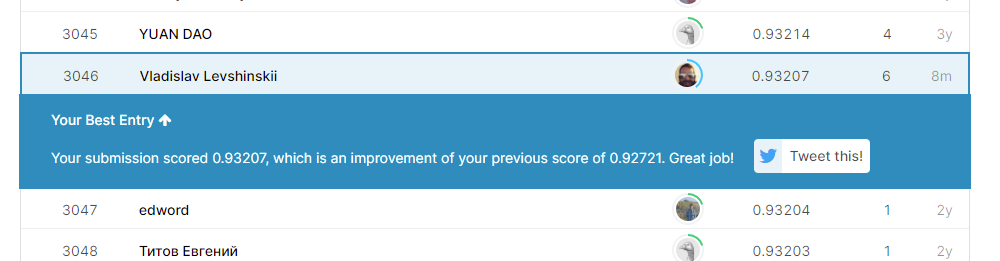

In [201]:
display.Image(b64decode(base64_img))

Второй бенчмарк побит

## Критерии оценки работы (только для Peer Review в специализации):
- Правильные ли получились размерности матриц в п. 1? (max. 2 балла)
- Правильным ли получилось значения ROC AUC в п. 2? (max. 4 балла)
- Побит ли бенчмарк "sgd_logit_benchmark.csv" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)
- Побит ли бенчмарк "Logit +3 features" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)

## Пути улучшения
На этой неделе дается много времени на соревнование. Не забывайте вносить хорошие идеи, к которым Вы пришли по ходу соревнования, в описание финального проекта (`html`, `pdf` или `ipynb`). Это только в случае, если вы проходите специализацию.
Что можно попробовать:
 - Использовать ранее построенные признаки для улучшения модели (проверить их можно на меньшей выборке по 150 пользователям, отделив одного из пользователей от остальных – это быстрее)
 - Настроить параметры моделей (например, коэффициенты регуляризации)
 - Если позволяют мощности (или хватает терпения), можно попробовать смешивание (блендинг) ответов бустинга и линейной модели. [Вот](http://mlwave.com/kaggle-ensembling-guide/) один из самых известных тьюториалов по смешиванию ответов алгоритмов, также хороша [статья](https://alexanderdyakonov.wordpress.com/2017/03/10/cтекинг-stacking-и-блендинг-blending) Александра Дьяконова
 - Обратите внимание, что в соревновании также даны исходные данные о посещенных веб-страницах Элис и остальными 1557 пользователями (*train.zip*). По этим данным можно сформировать свою обучающую выборку. 

На 6 неделе мы пройдем большой тьюториал по Vowpal Wabbit и попробуем его в деле, на данных соревнования.